## seaborn

In [1]:
import os
import numpy as np
import anndata as ad
import pandas as pd

In [2]:
import sys
import os

# Define the path to the main folder
main_folder = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main_semi_test"

# Add it to sys.path
sys.path.append(main_folder)

from LCL_eval_final import LCL_Eval
from collections import Counter

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n

   lambda  unlabeled_per_batch  batch_size  train_overall_acc  \
0    0.01                   15         150              1.000   
1    0.02                   15         150              1.000   
2    0.05                   15         150              1.000   
3    0.10                   15         150              0.998   
4    0.20                   15         150              0.866   
5    0.30                   15         150              0.802   
6    0.50                   15         150              0.543   
7    0.70                   15         150              0.349   
8    1.00                   15         150              0.228   

   train_overall_rank  train_q25  train_q50  train_q75  test_overall_acc  \
0               1.000      1.000      1.000      1.000             0.119   
1               1.000      1.000      1.000      1.000             0.101   
2               1.000      1.000      1.000      1.000             0.071   
3               1.002      1.000      1.000  

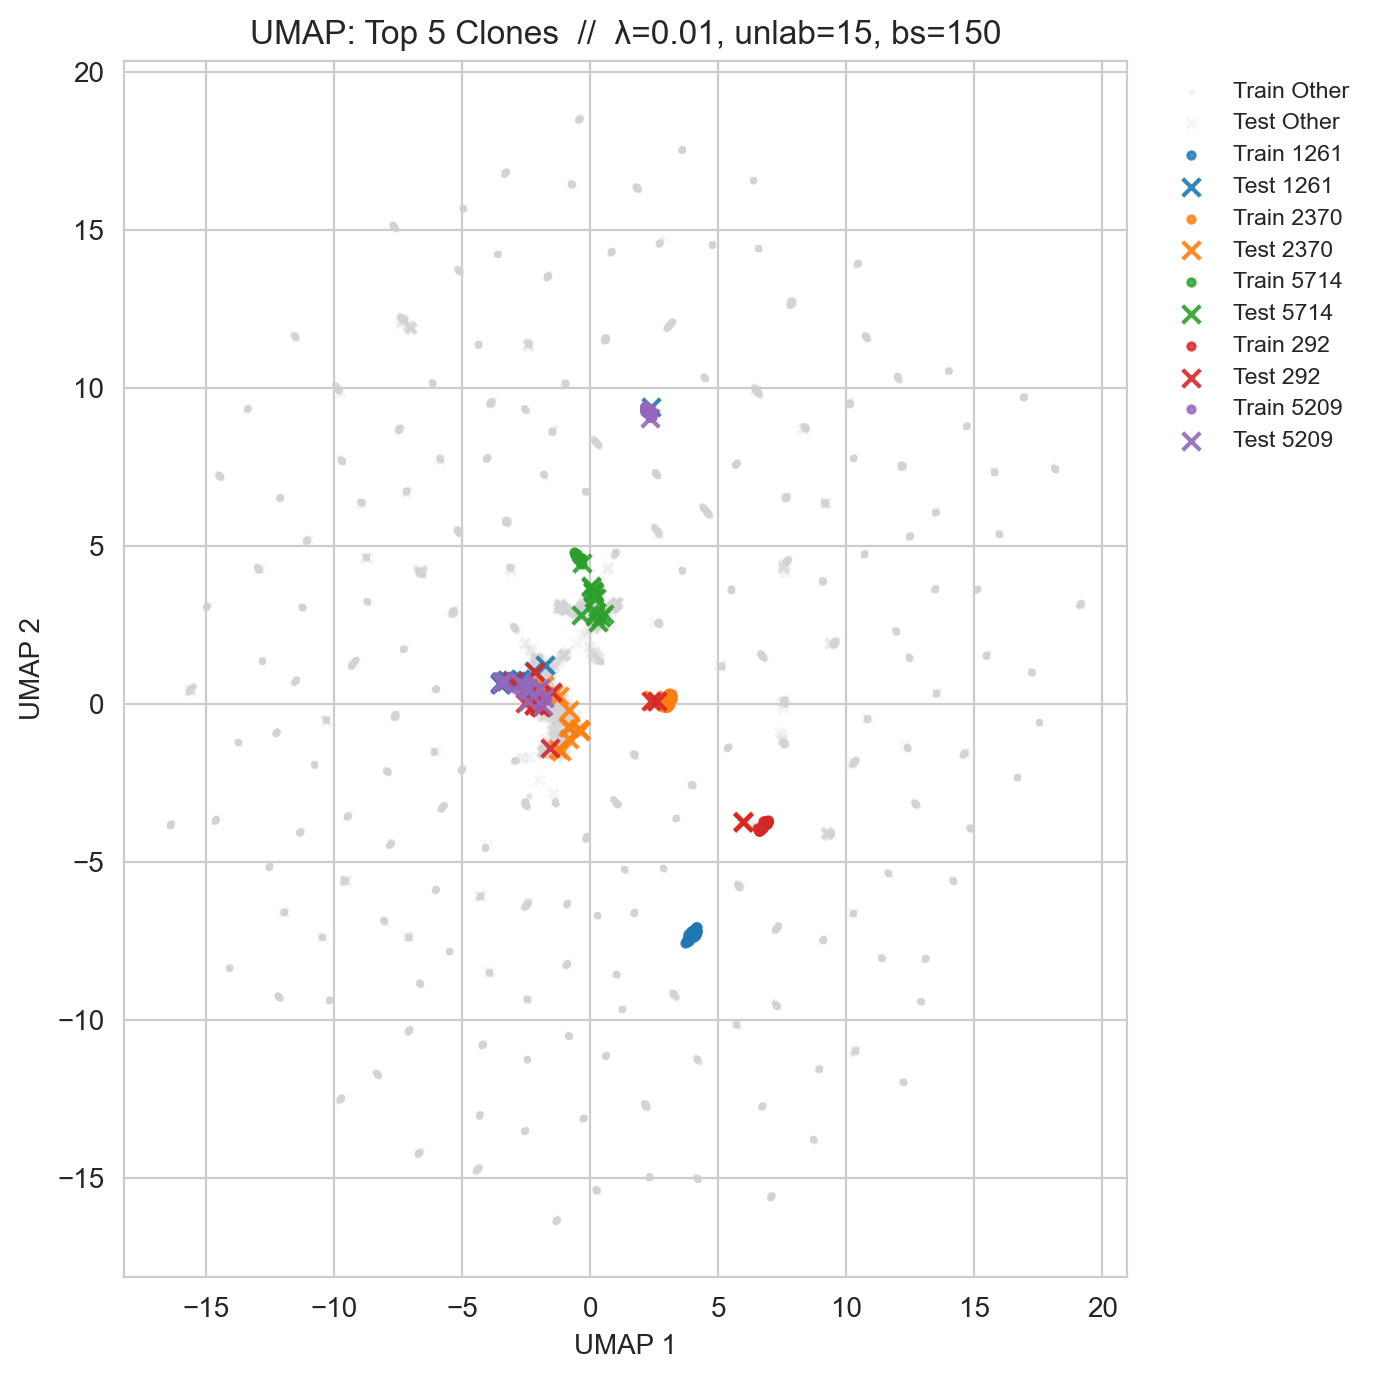

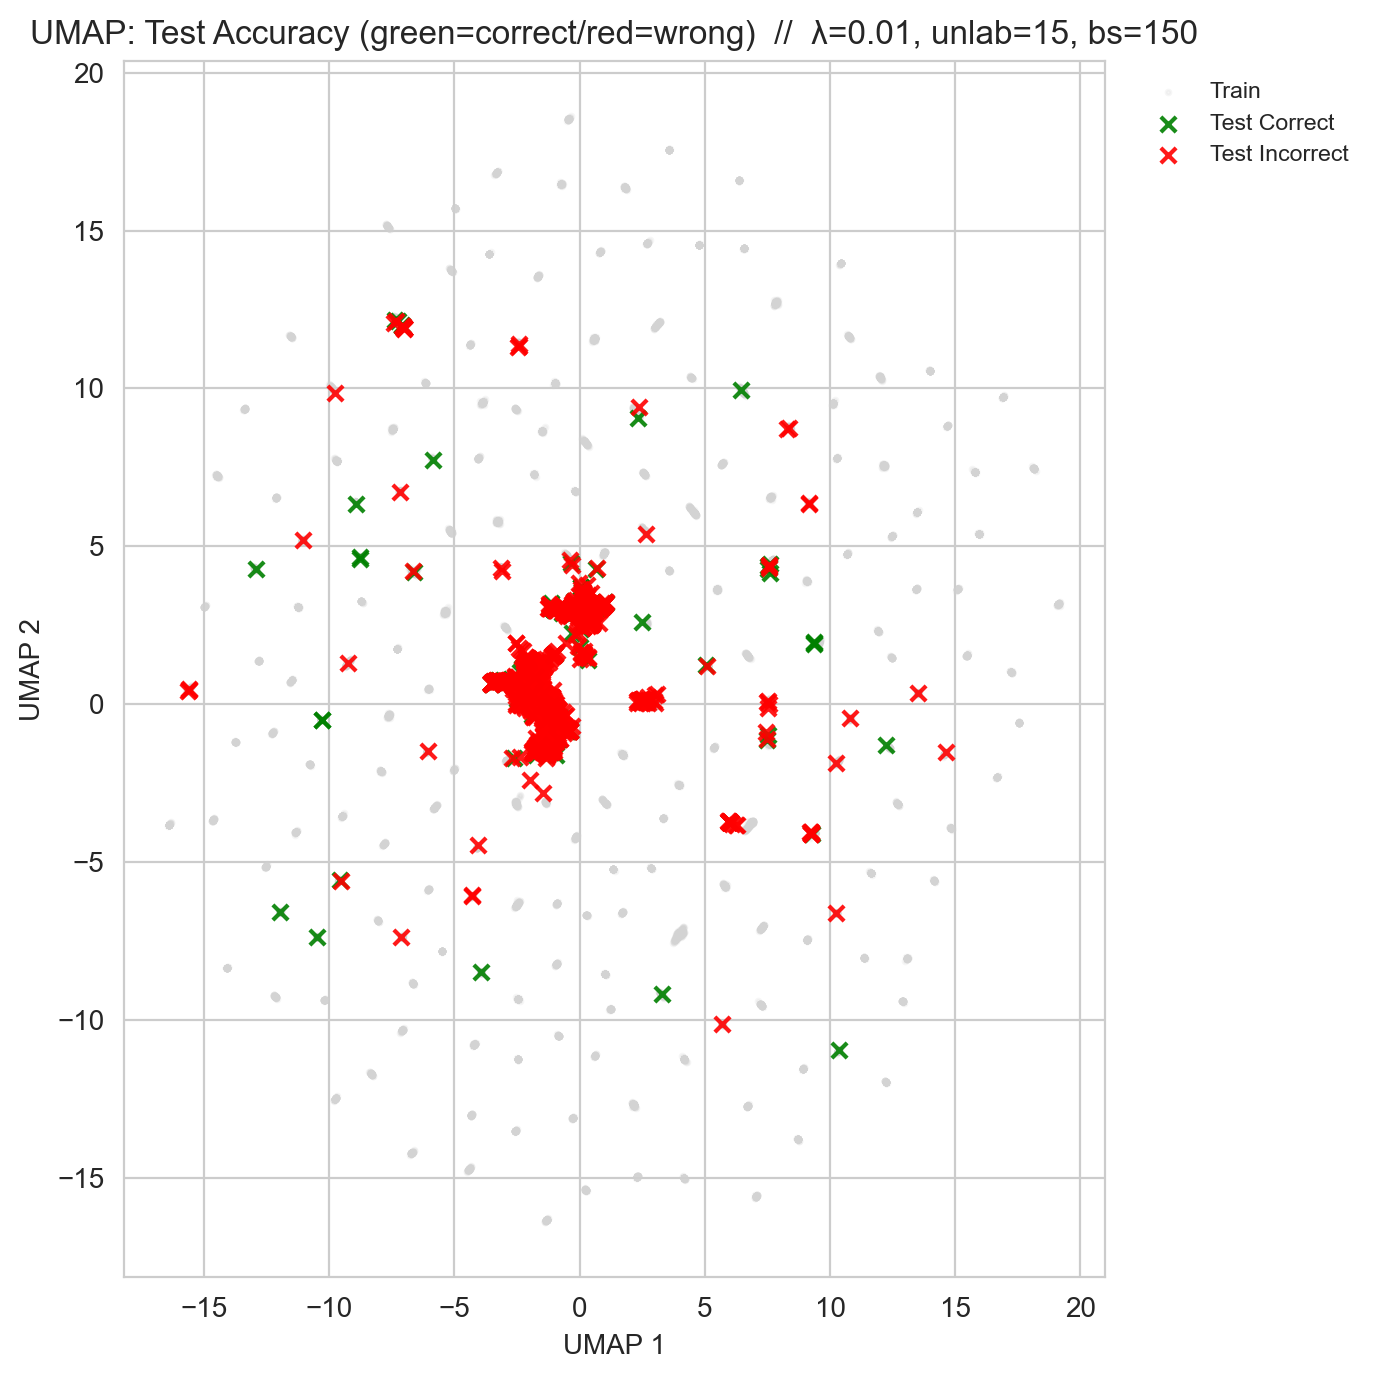

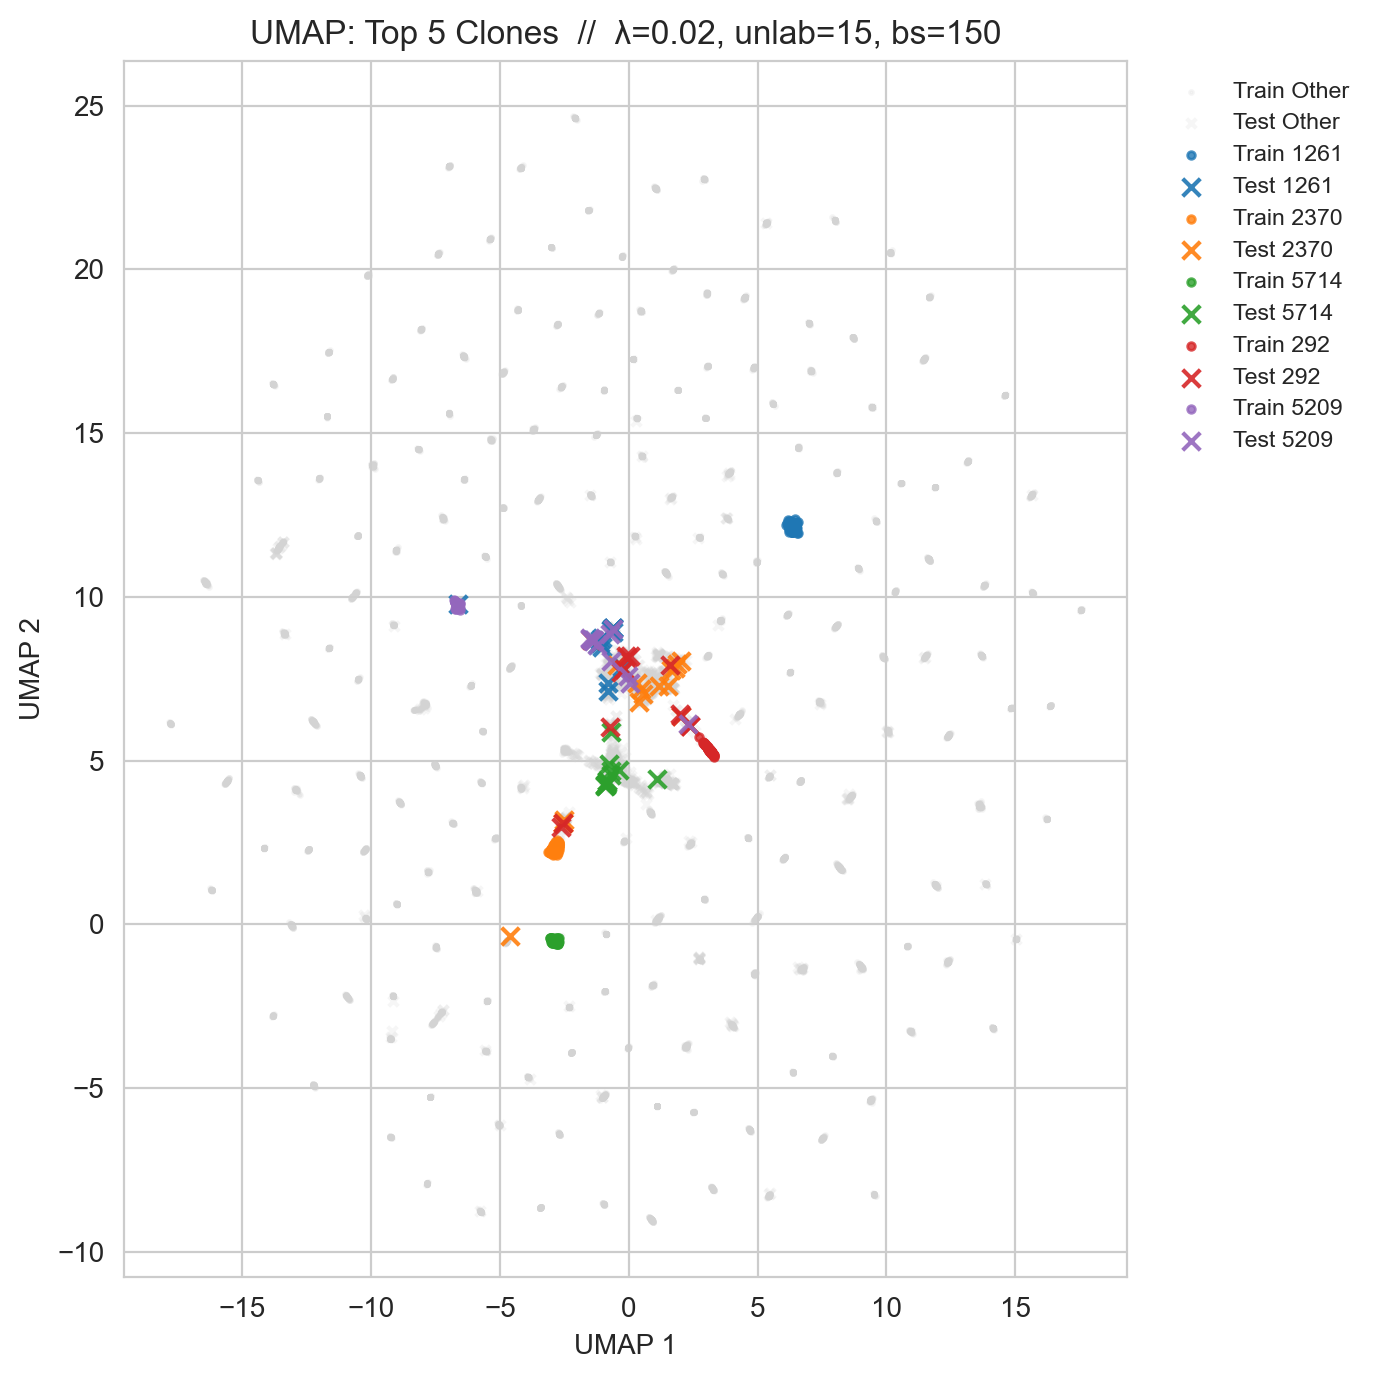

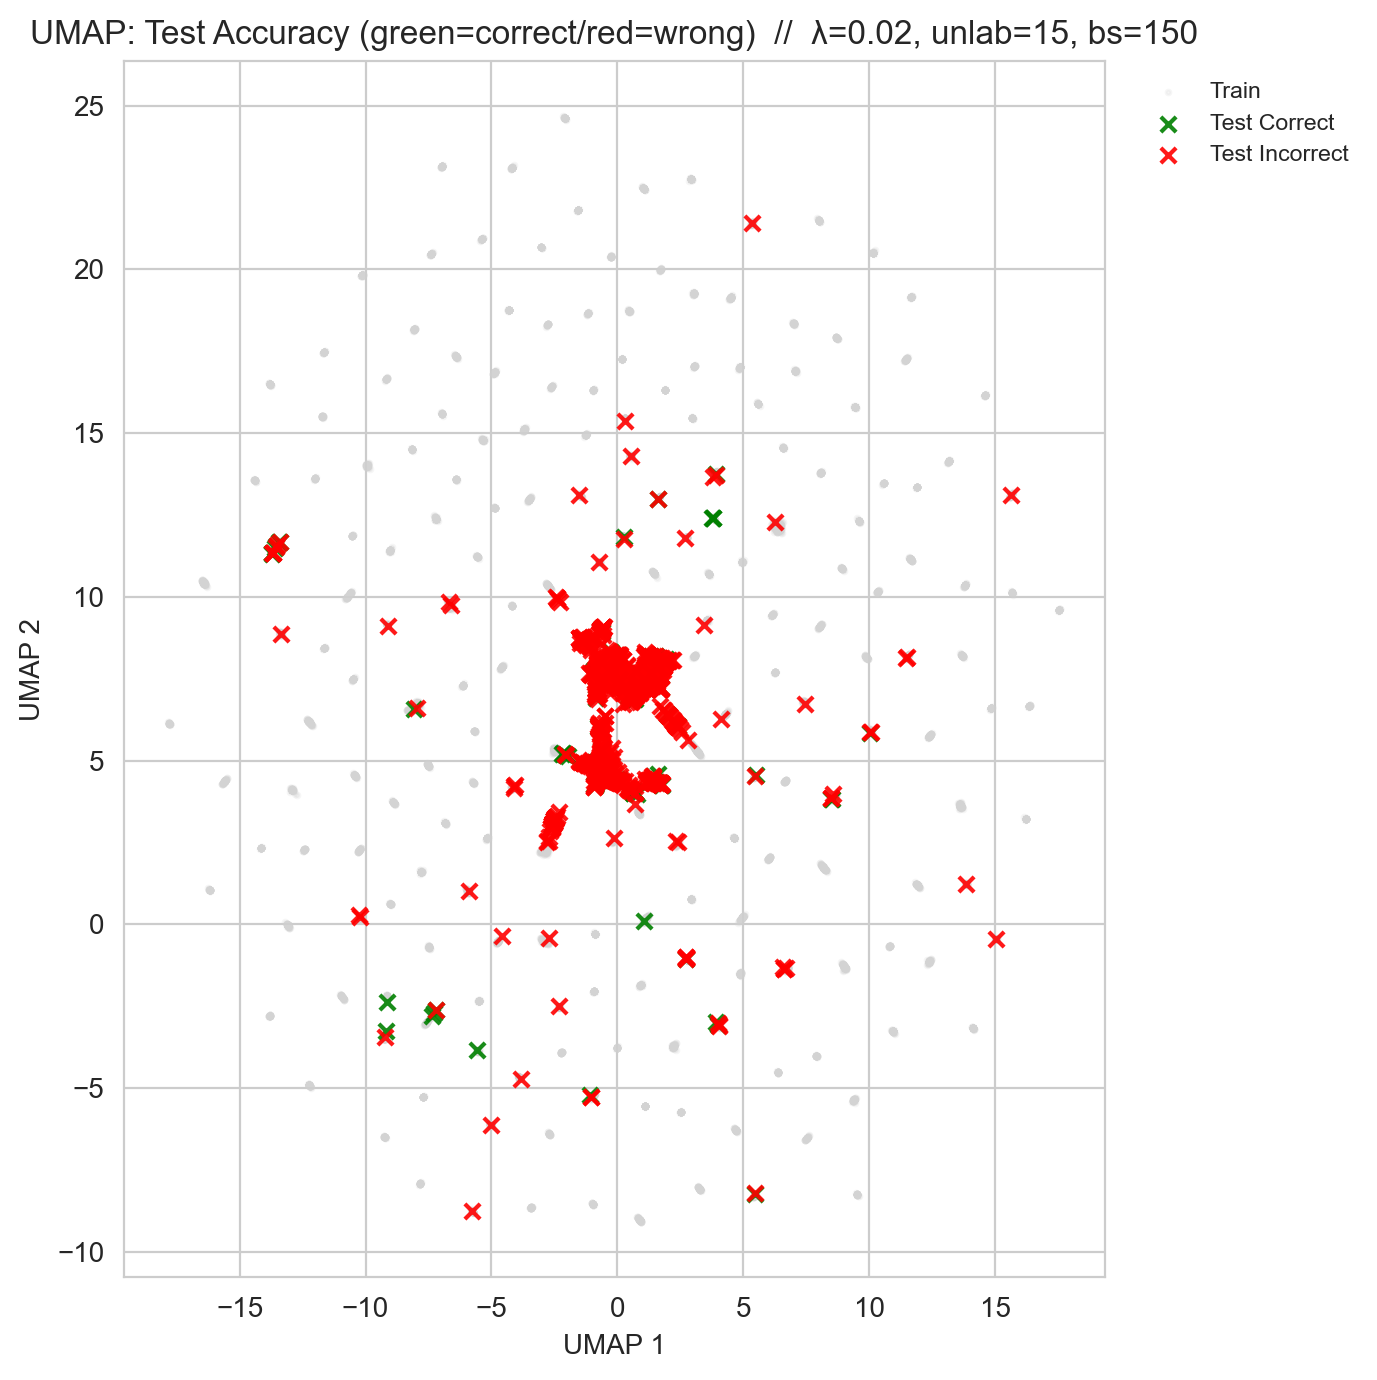

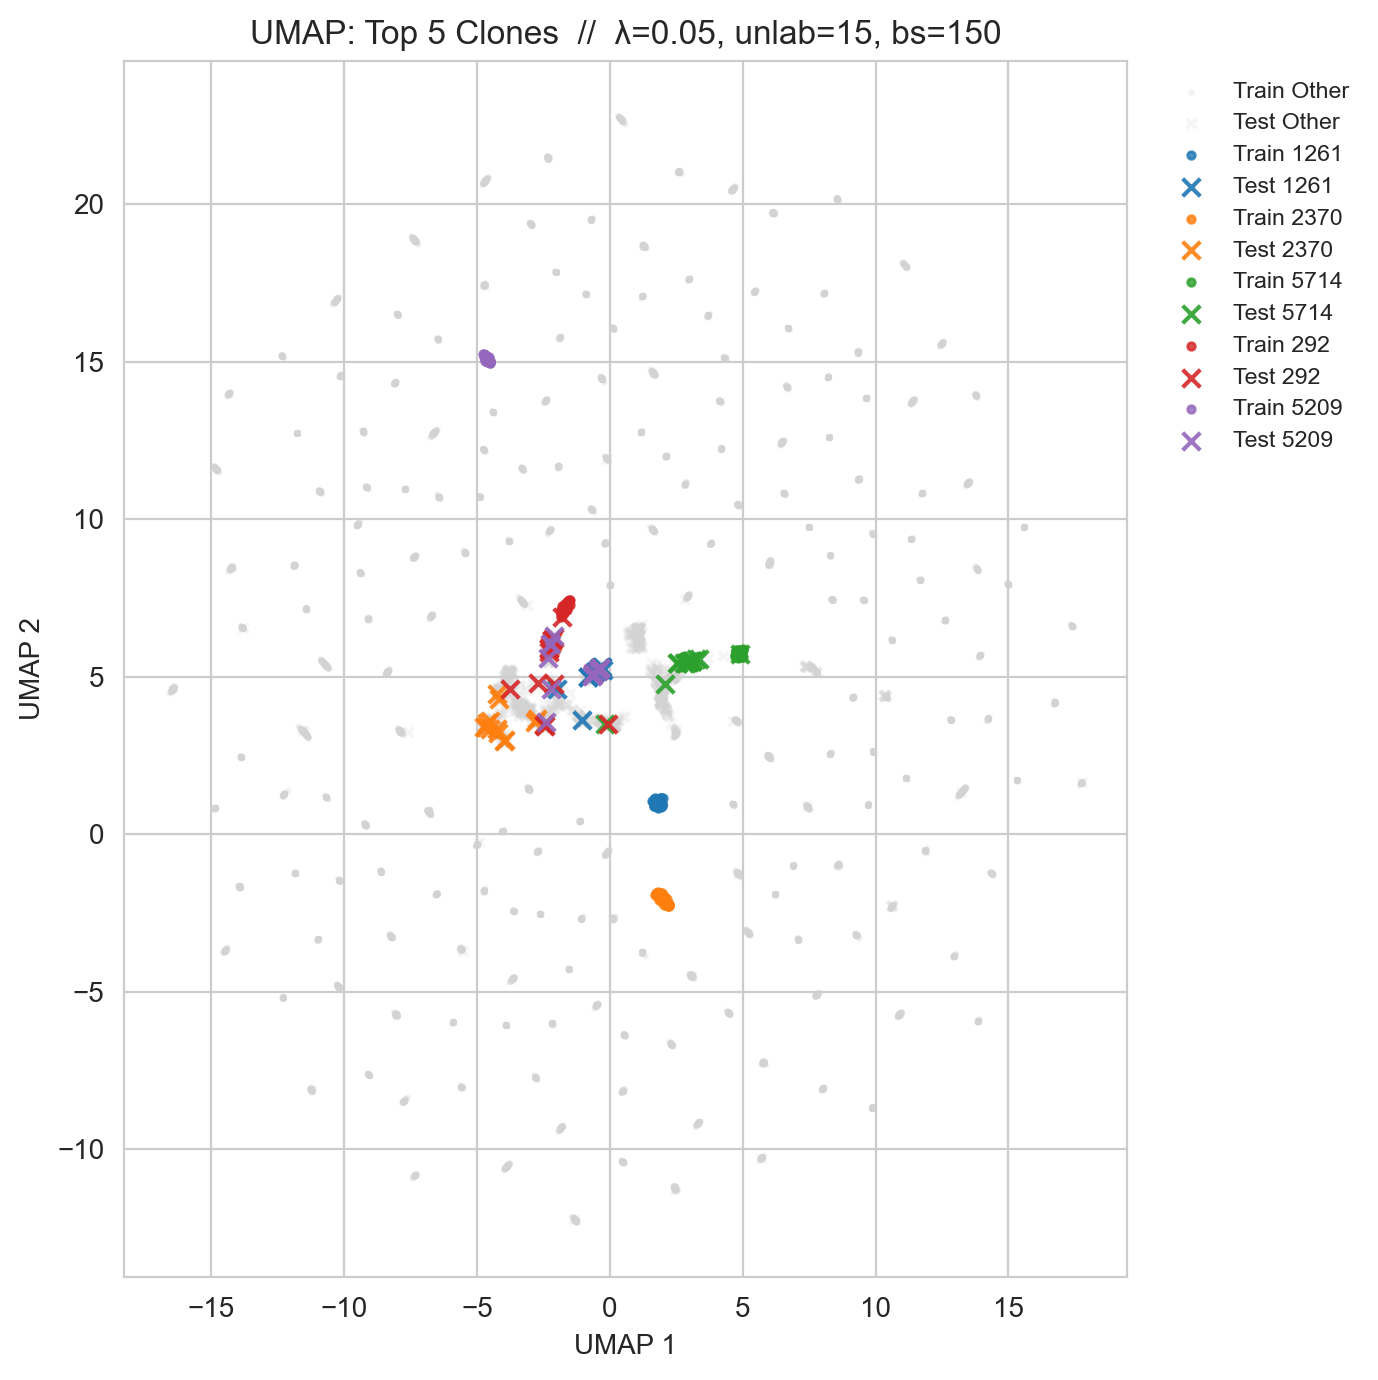

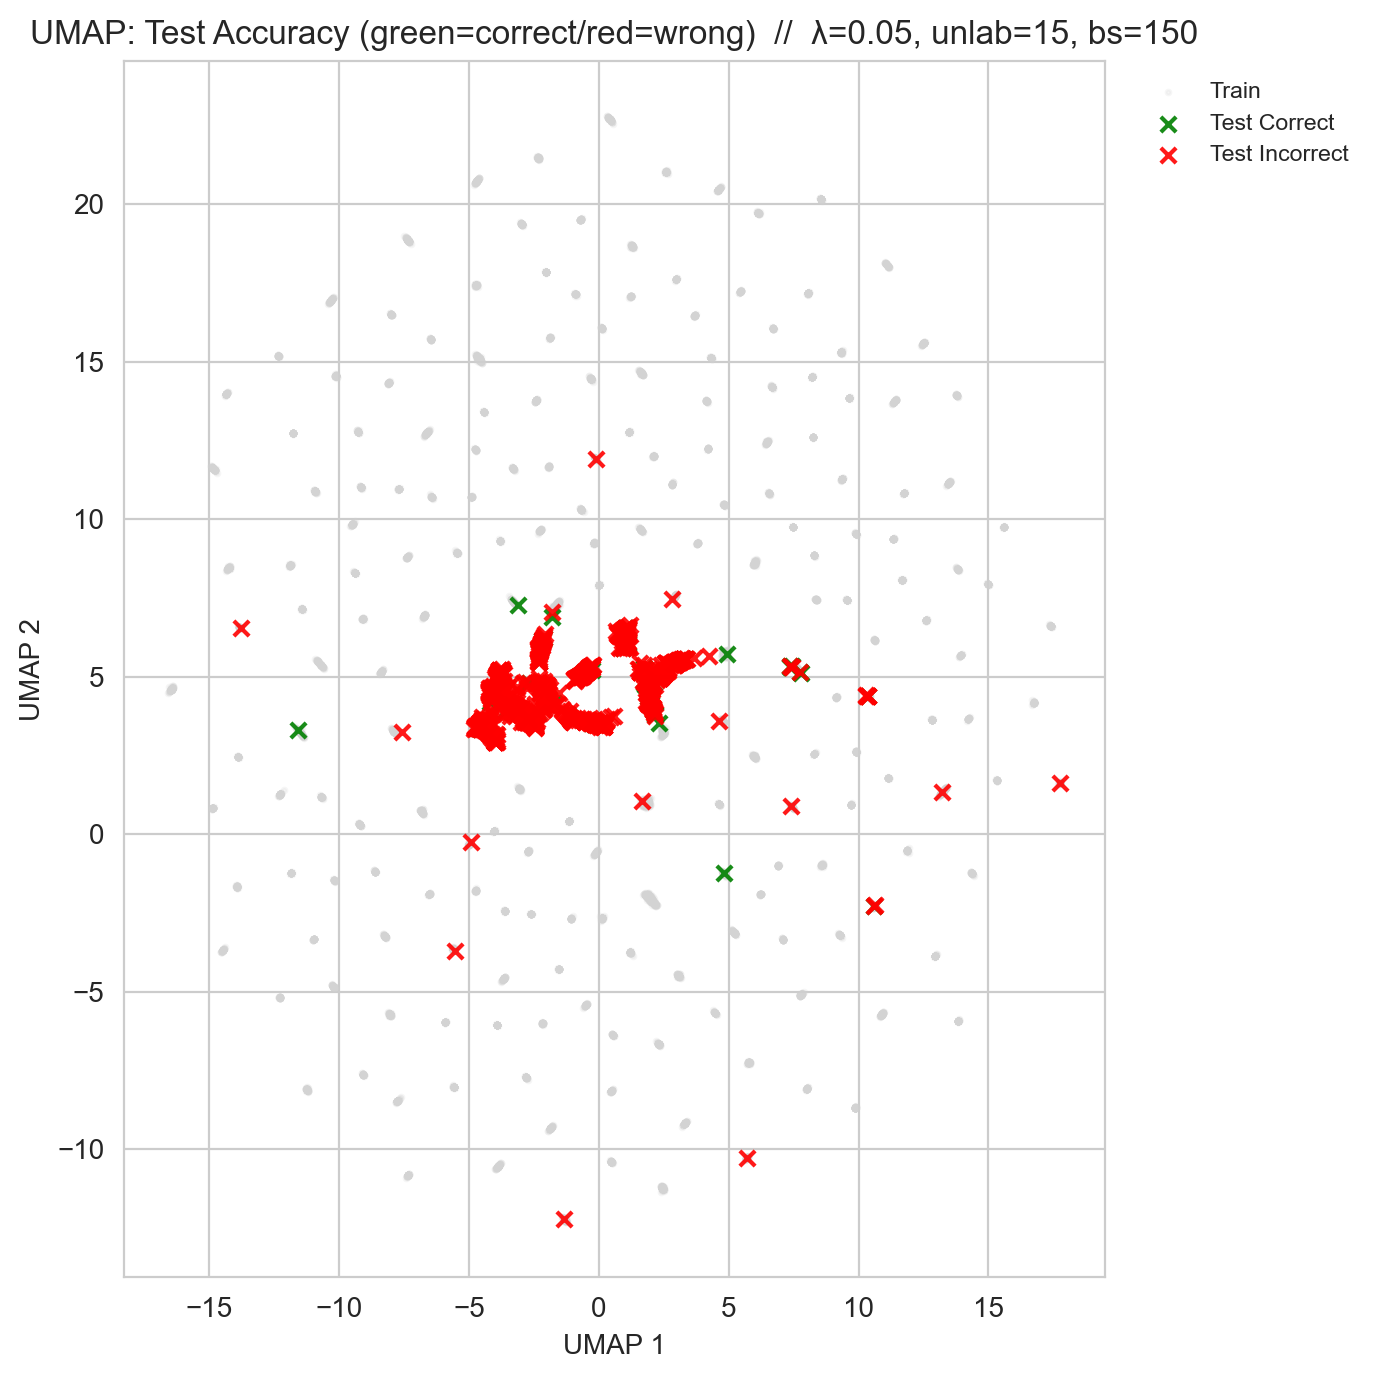

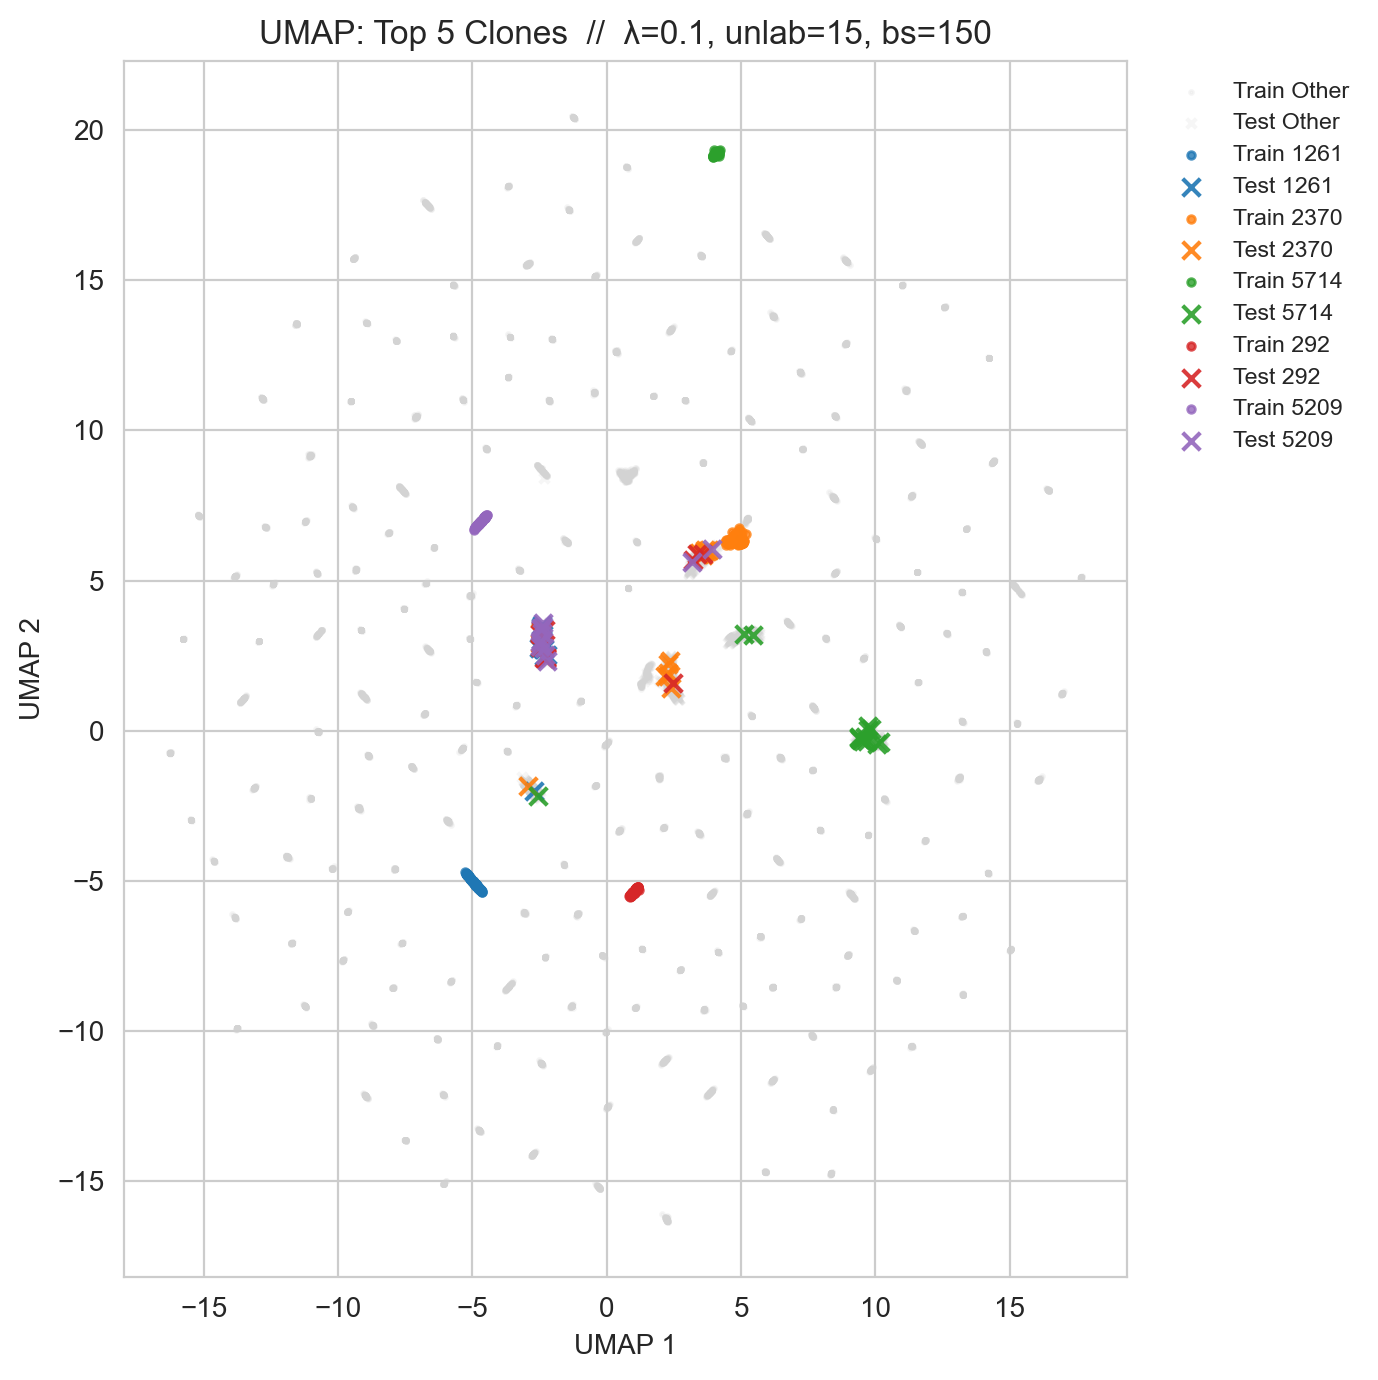

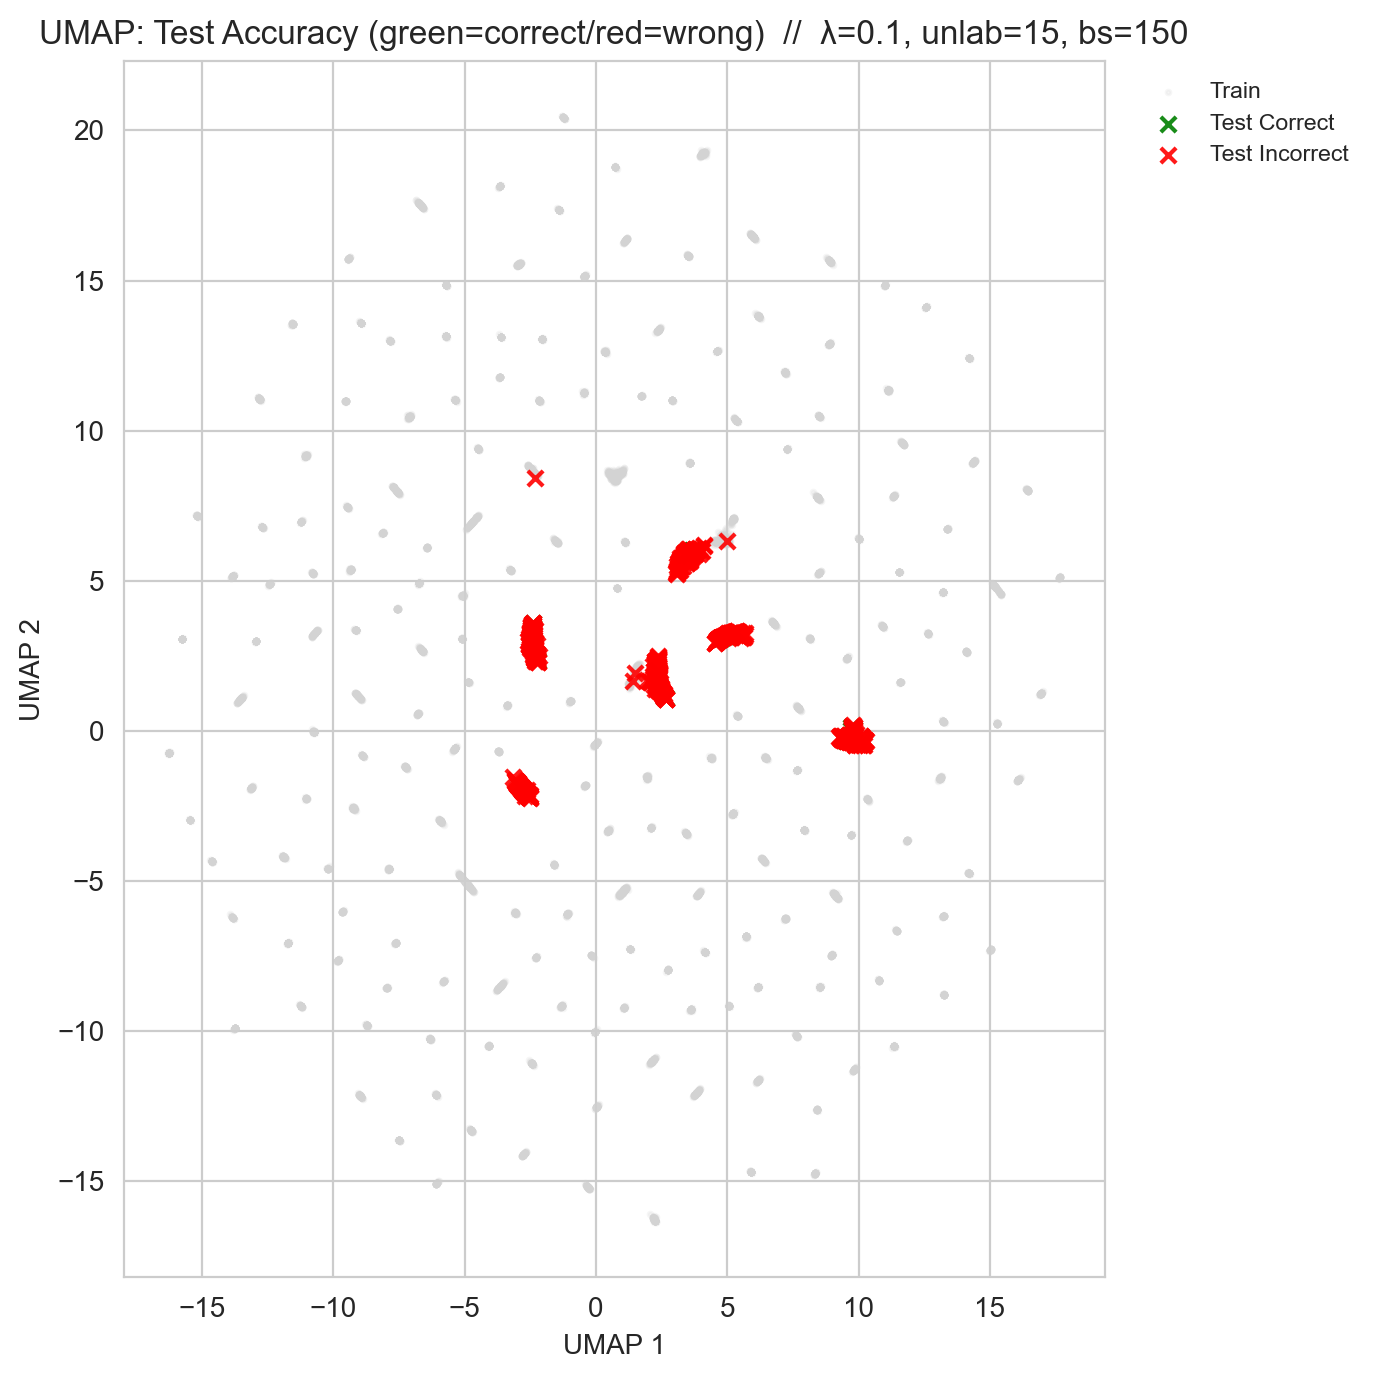

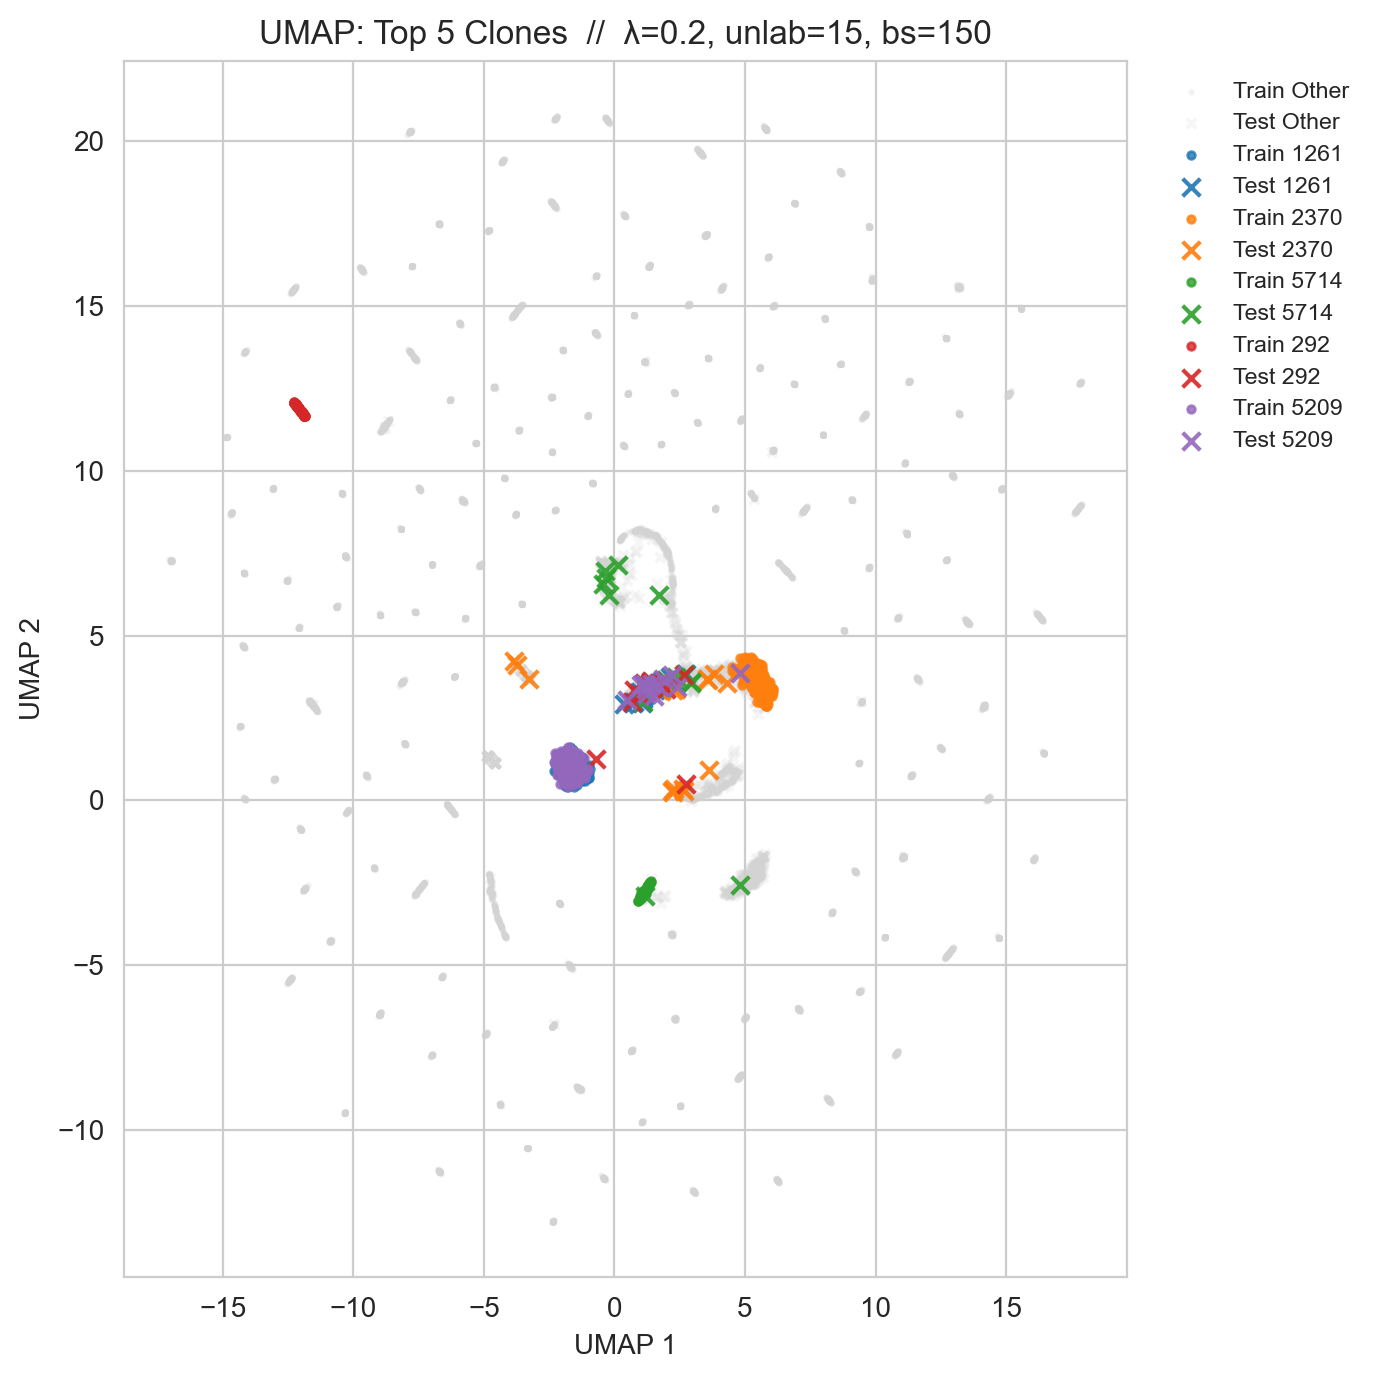

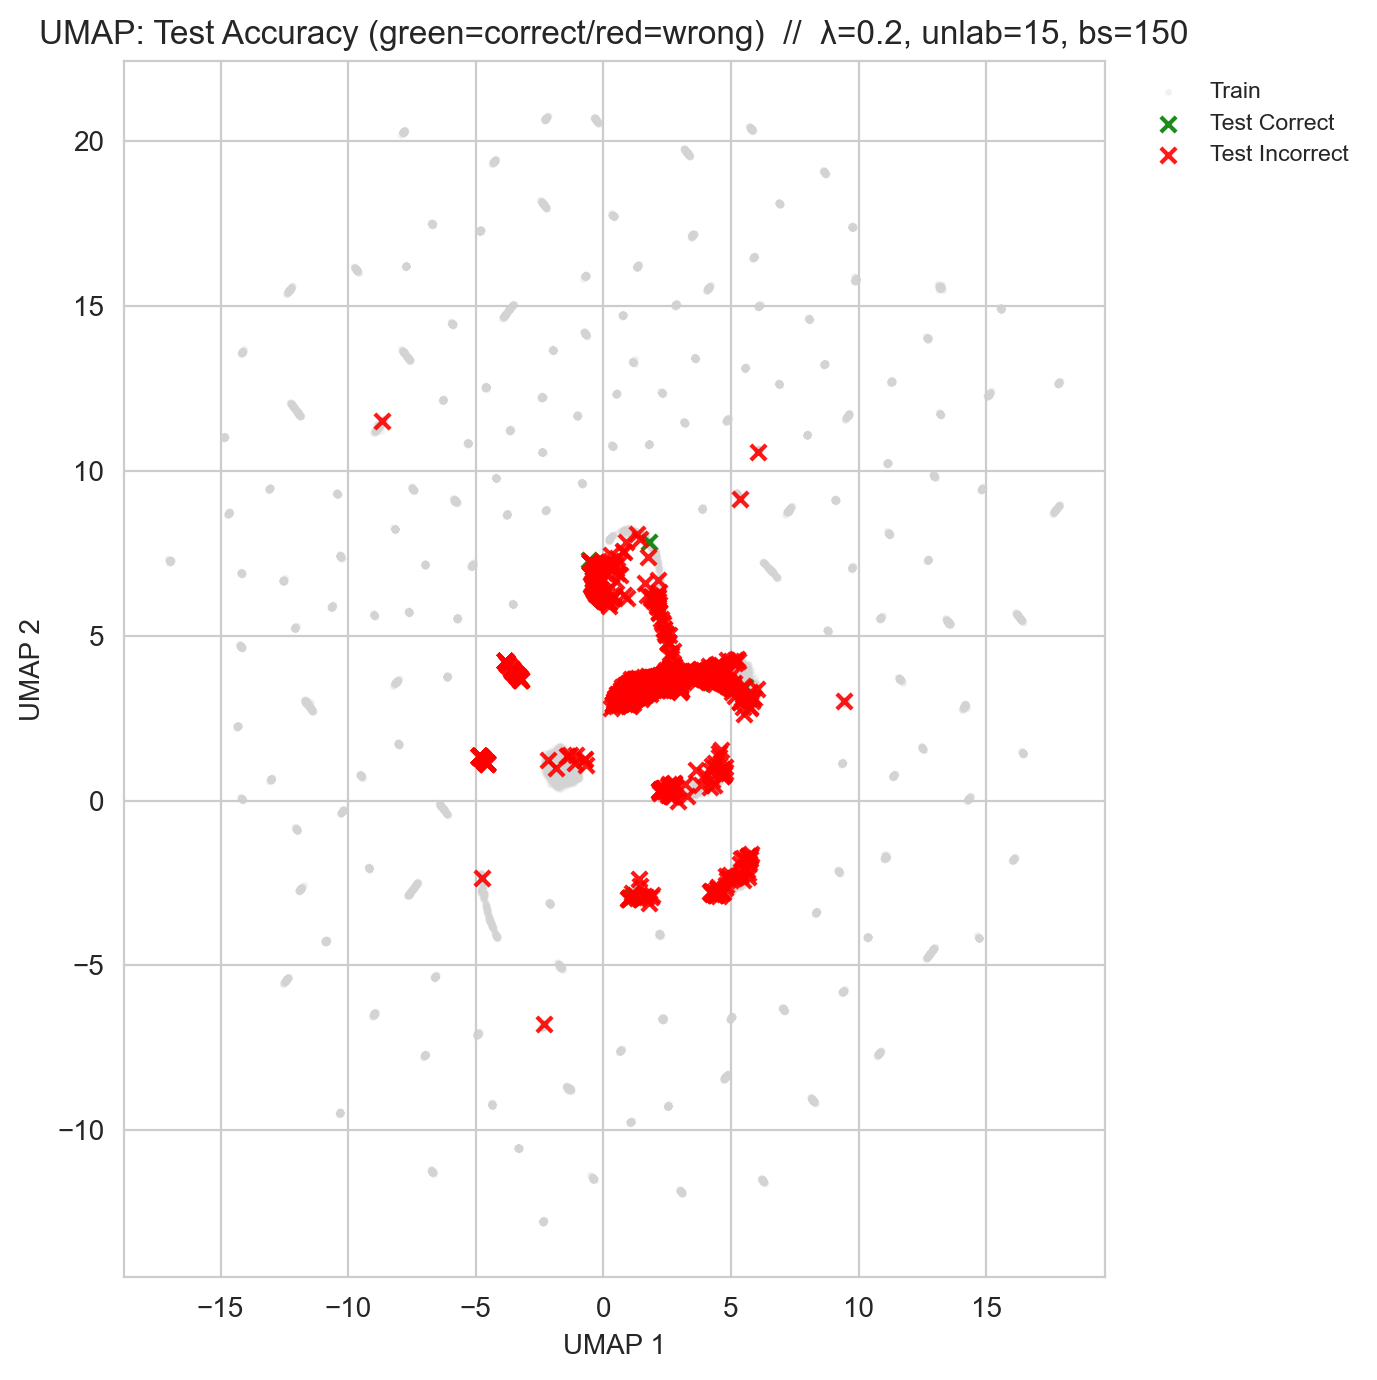

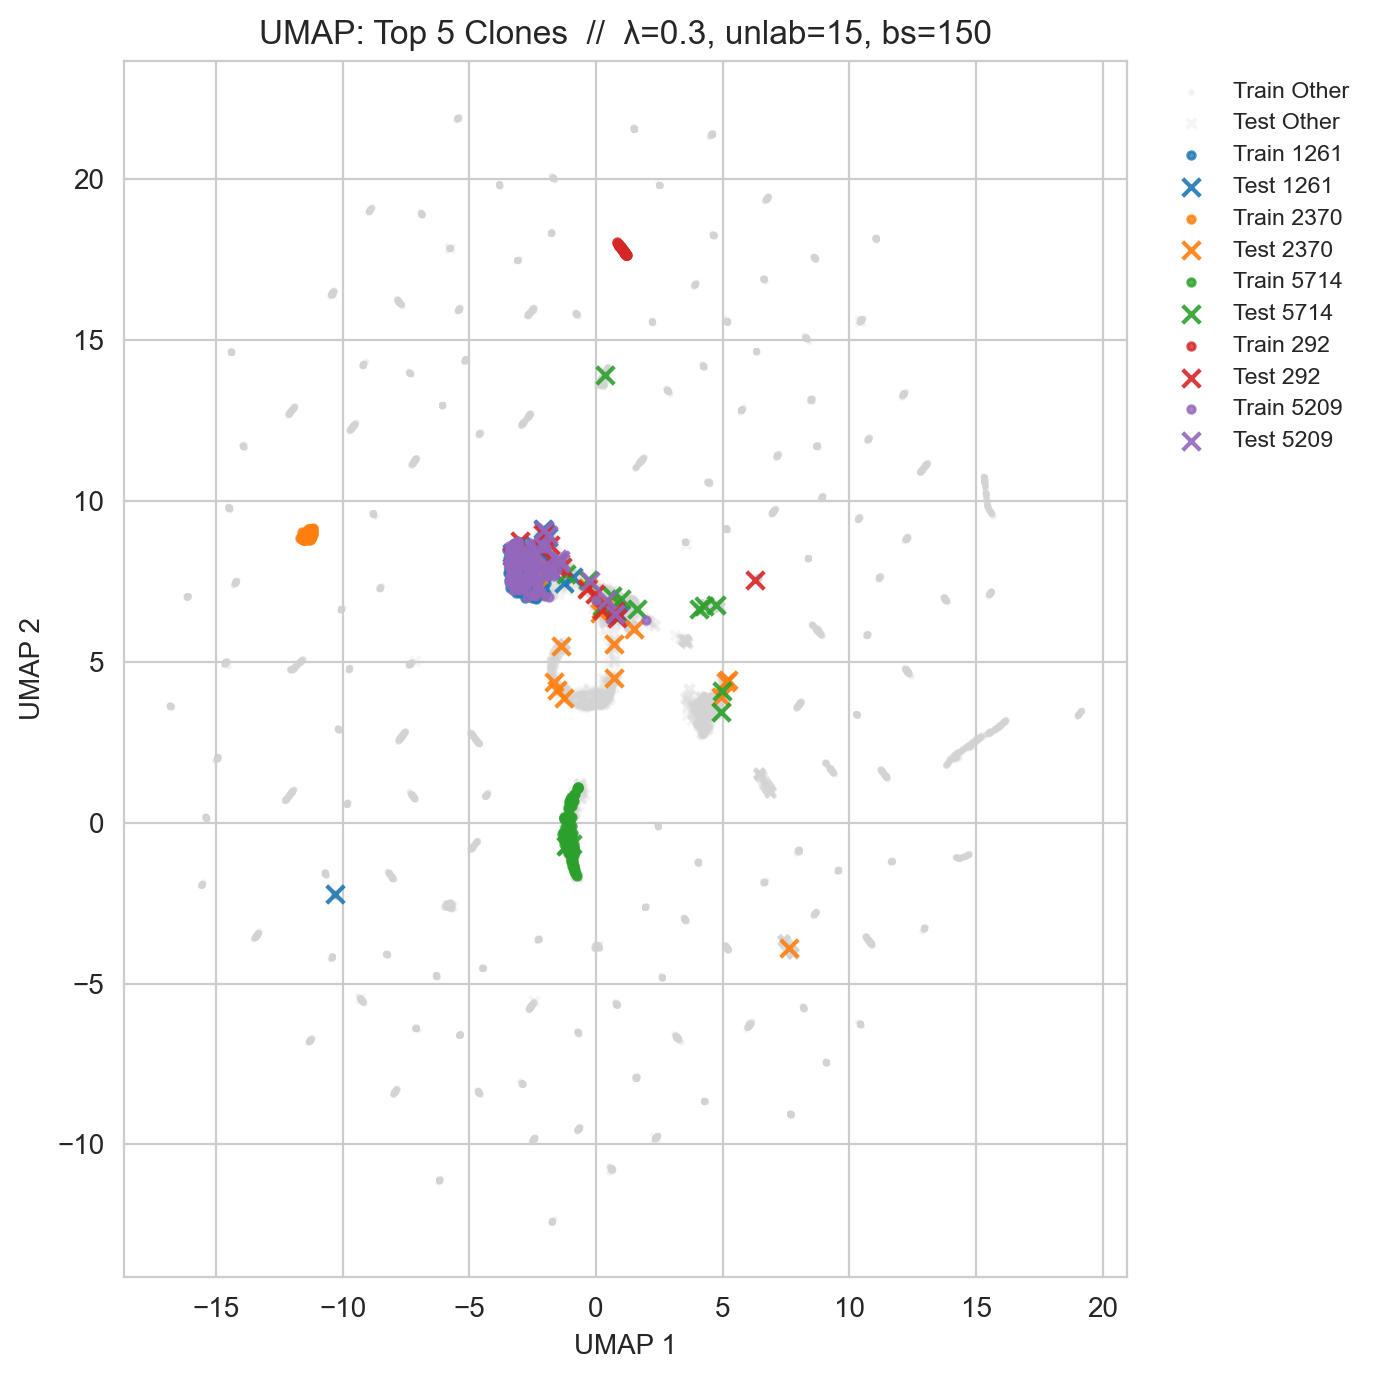

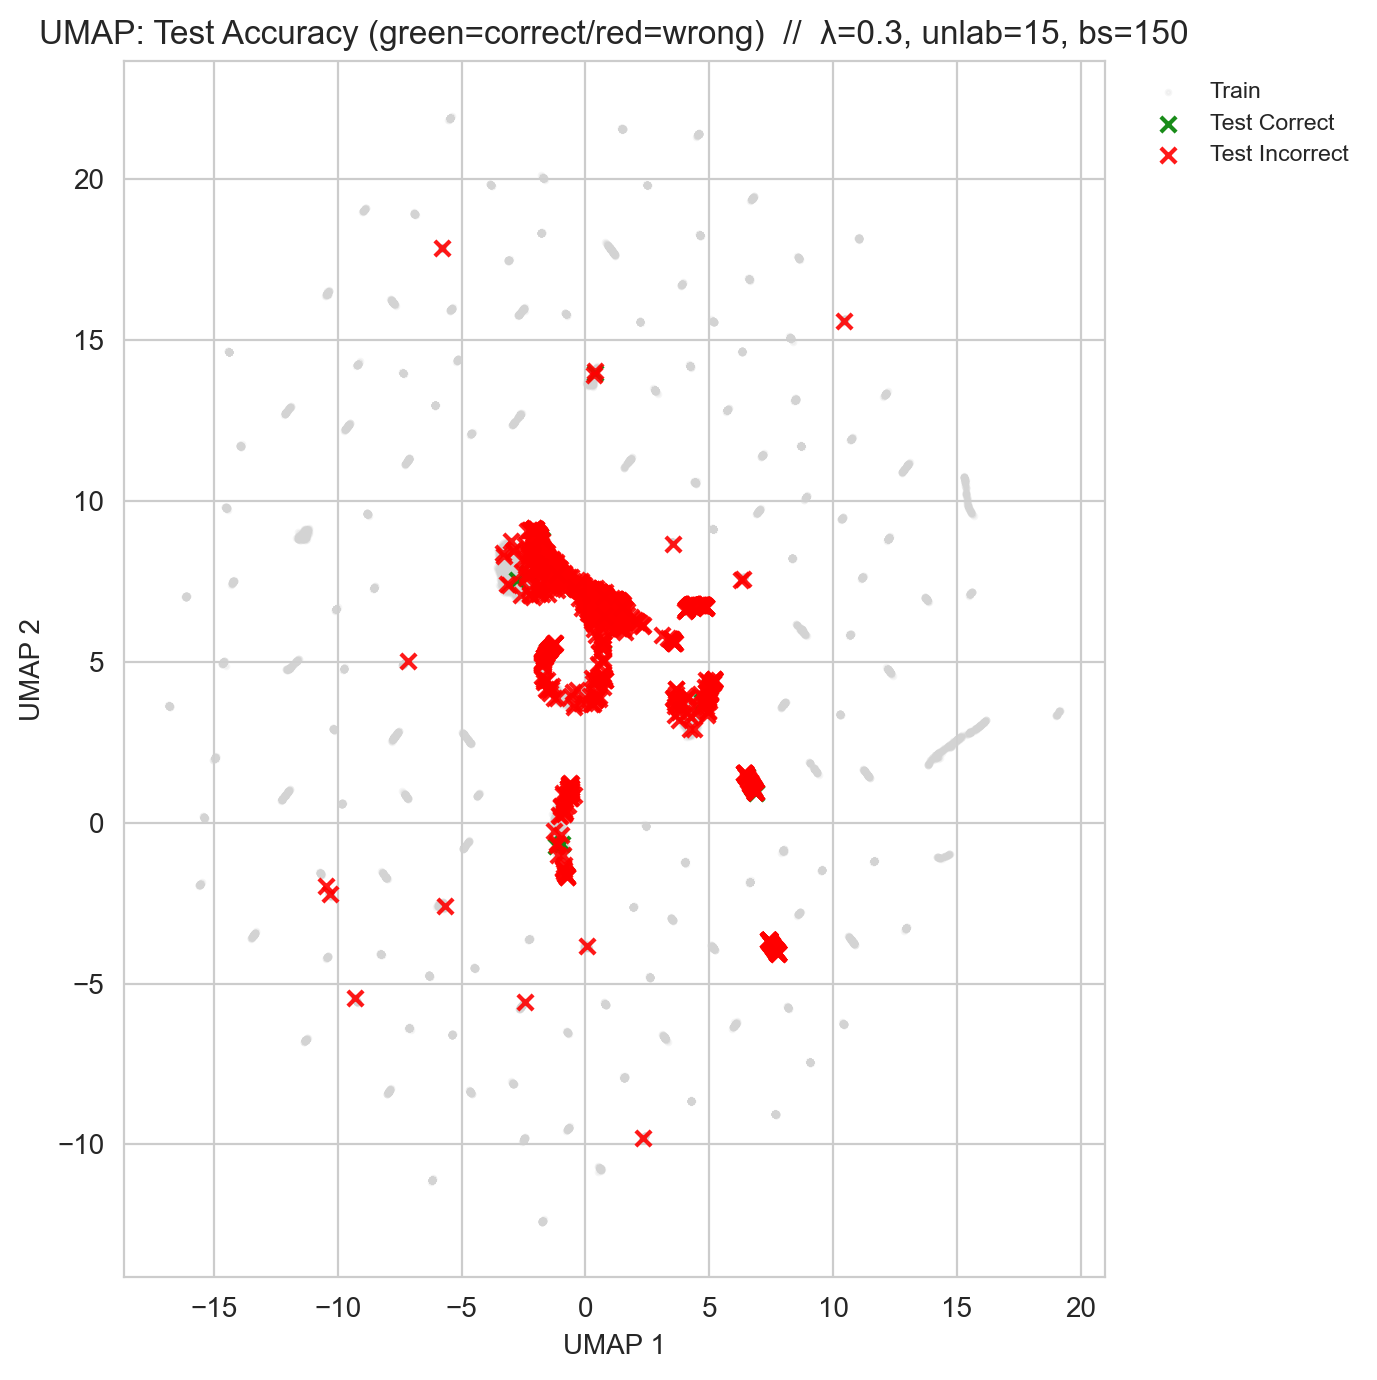

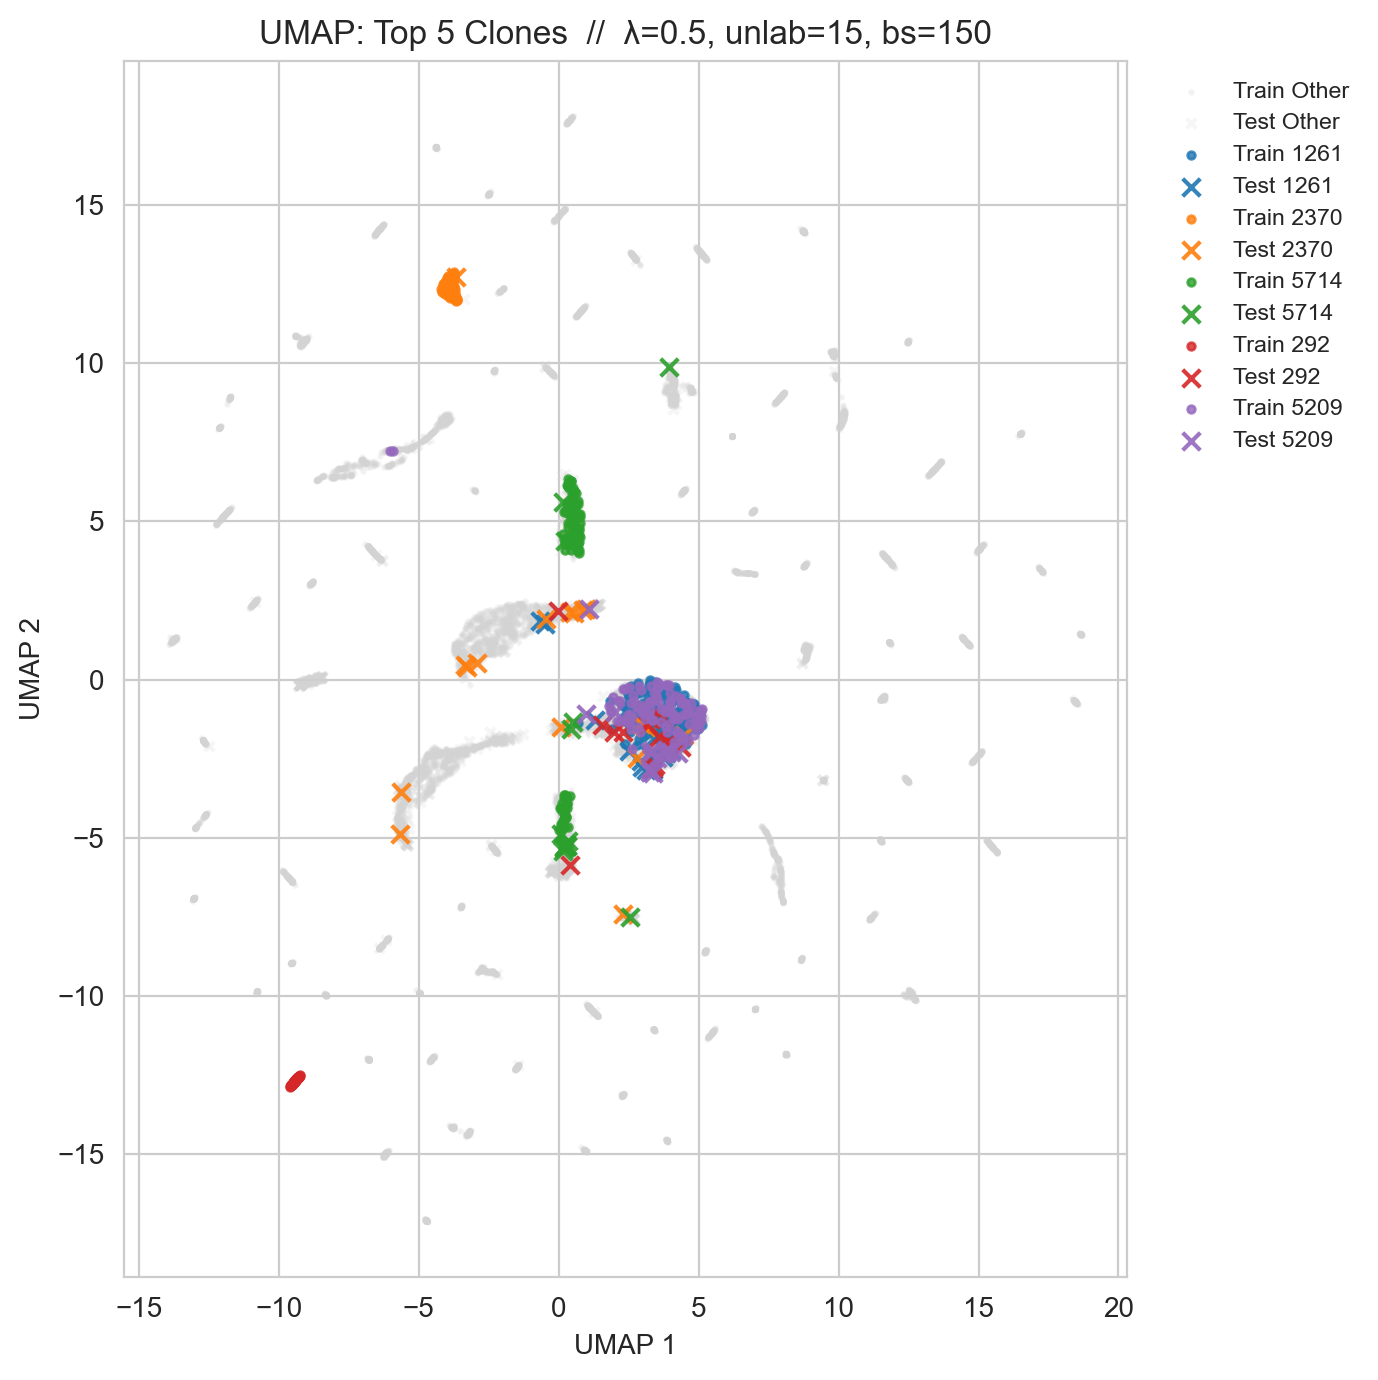

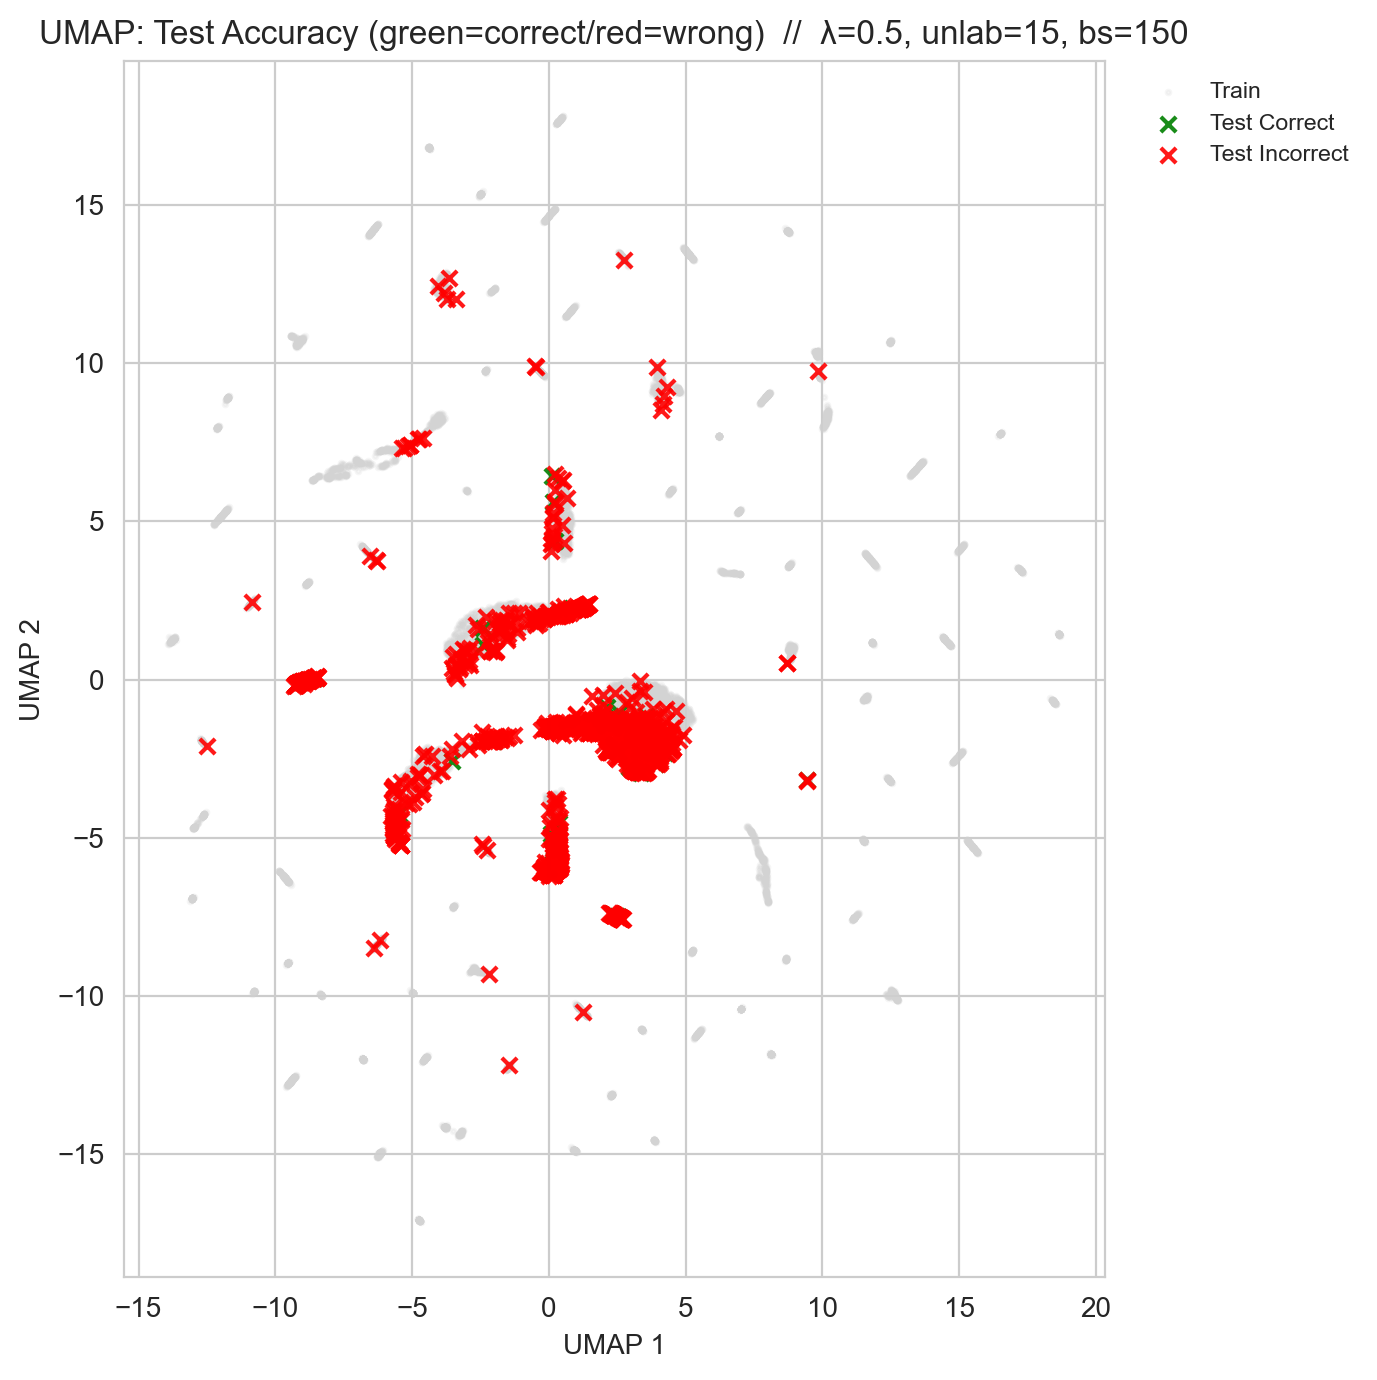

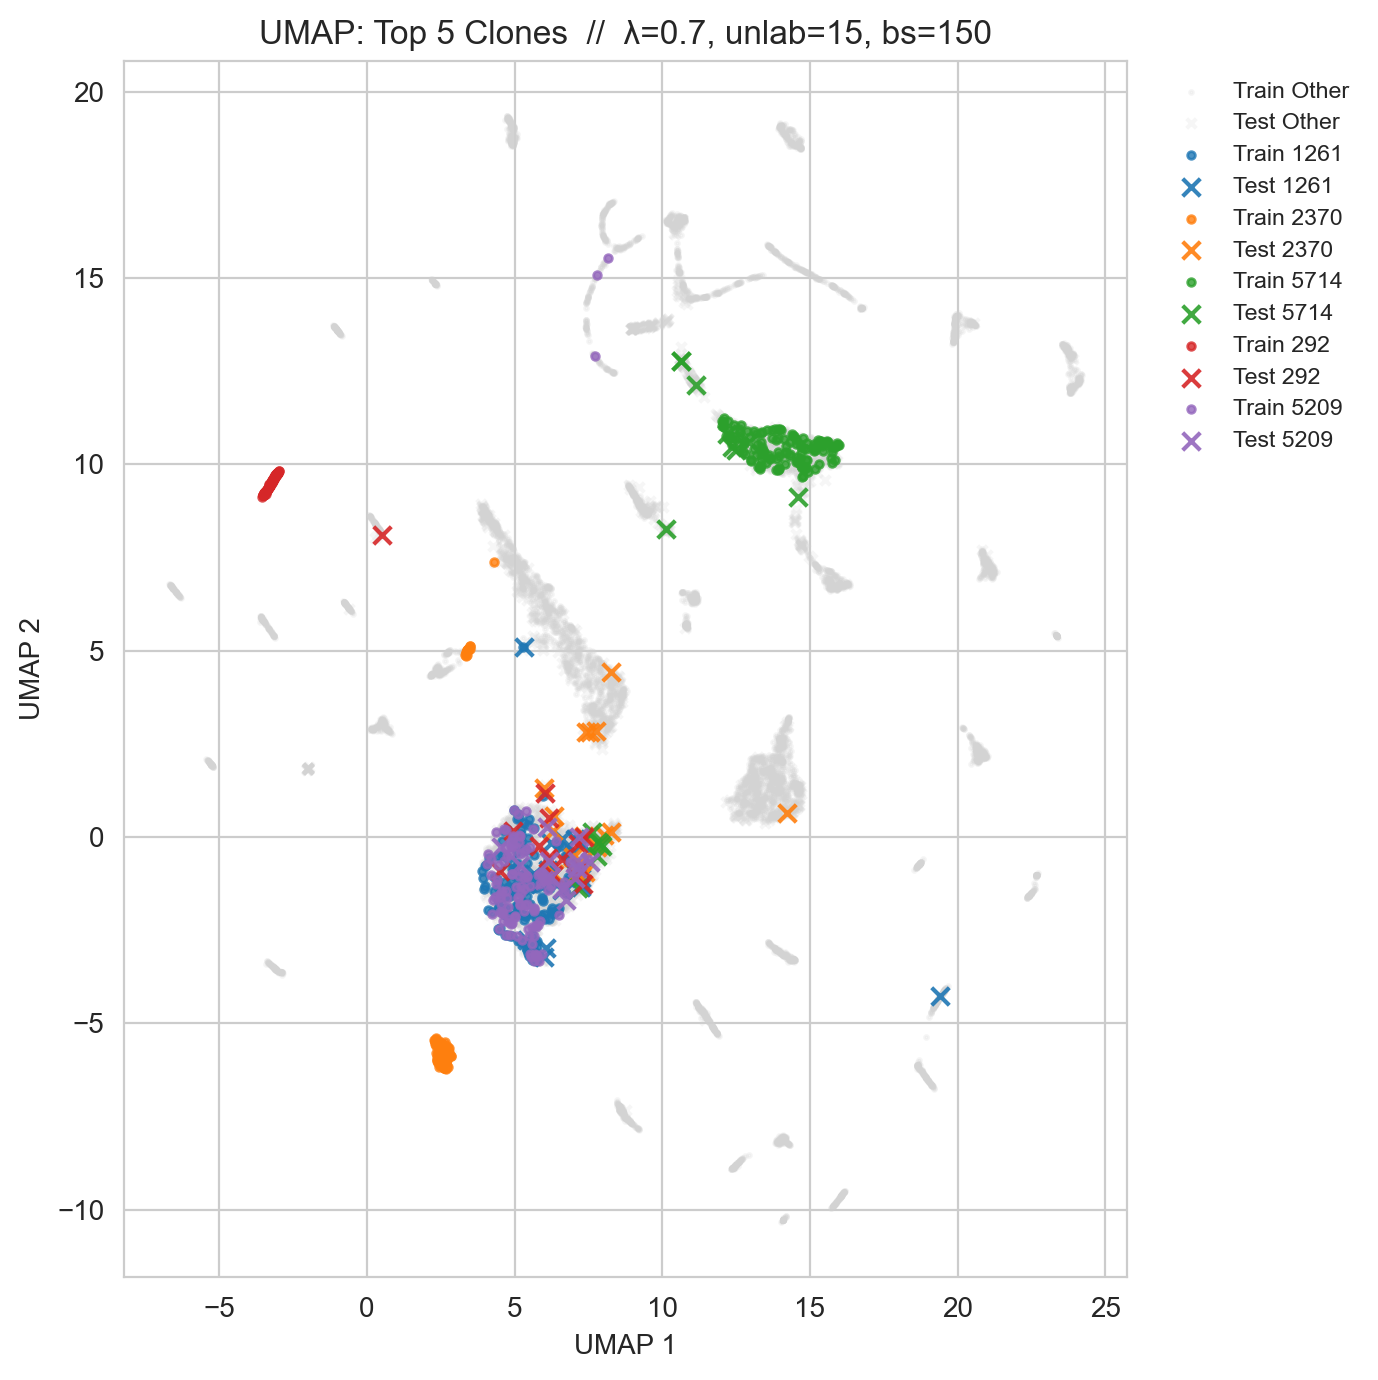

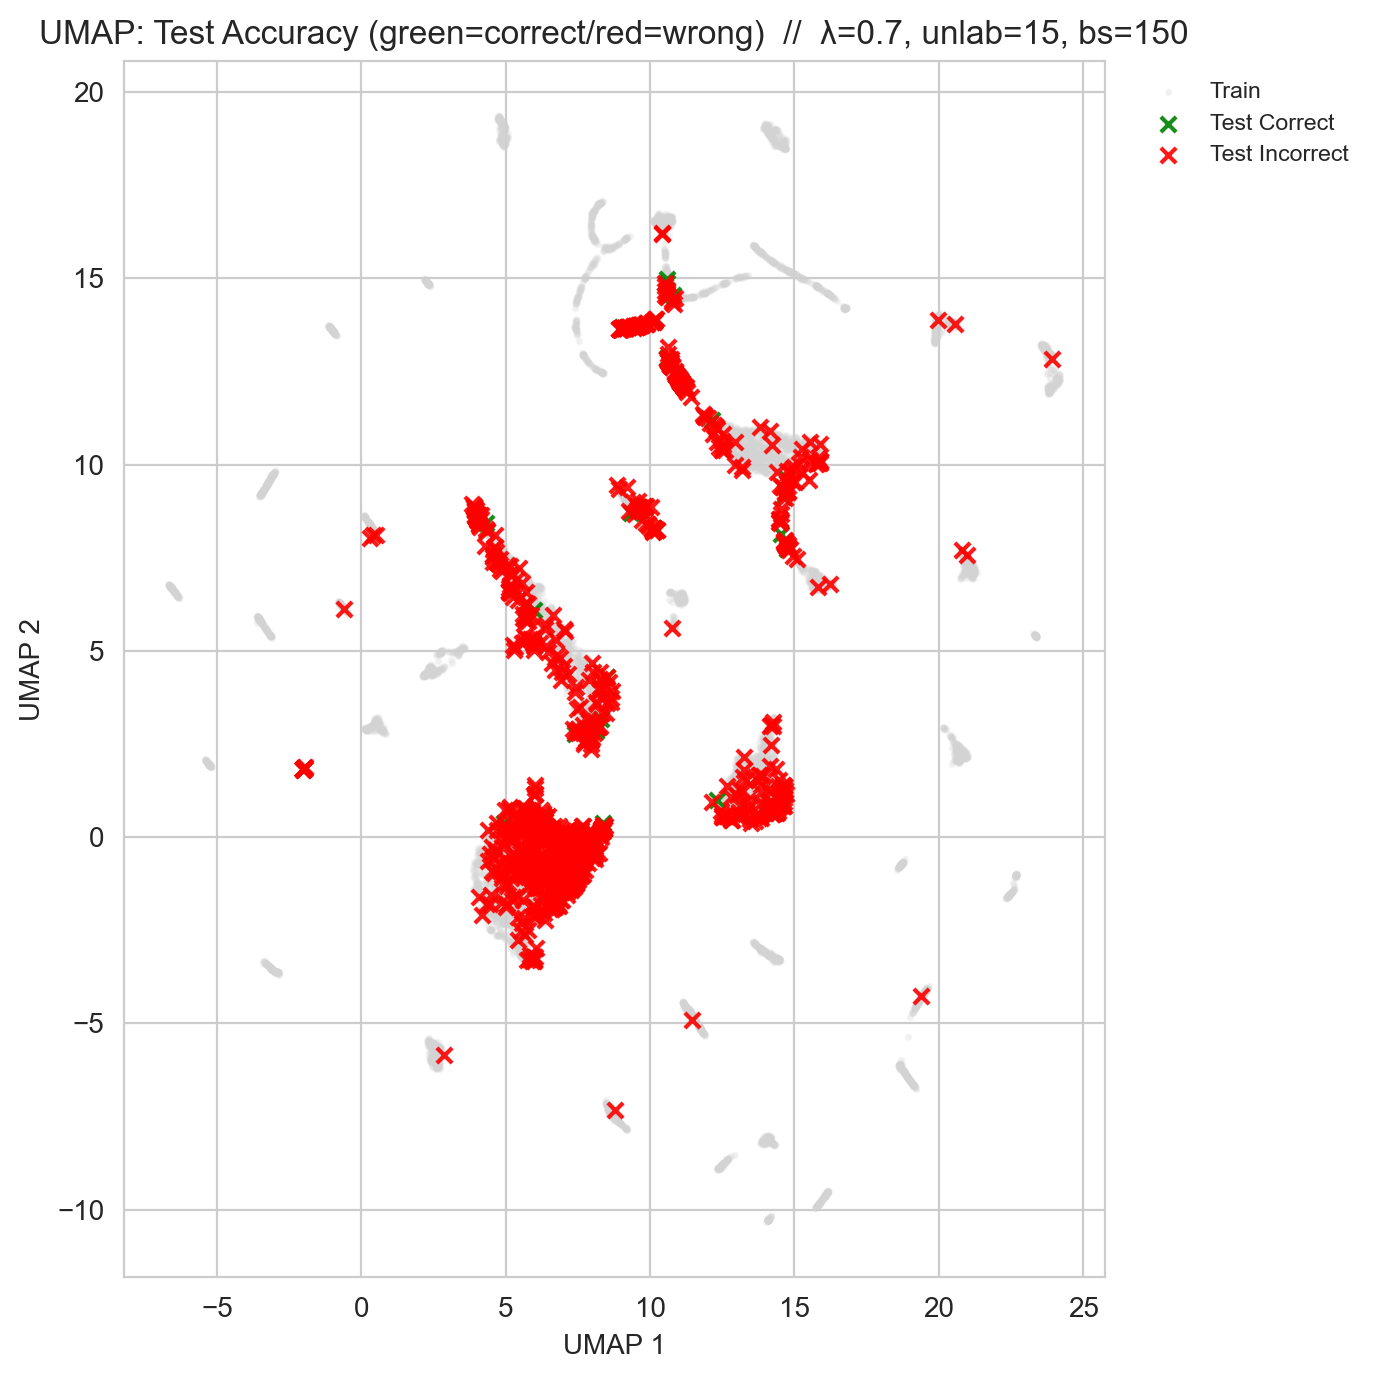

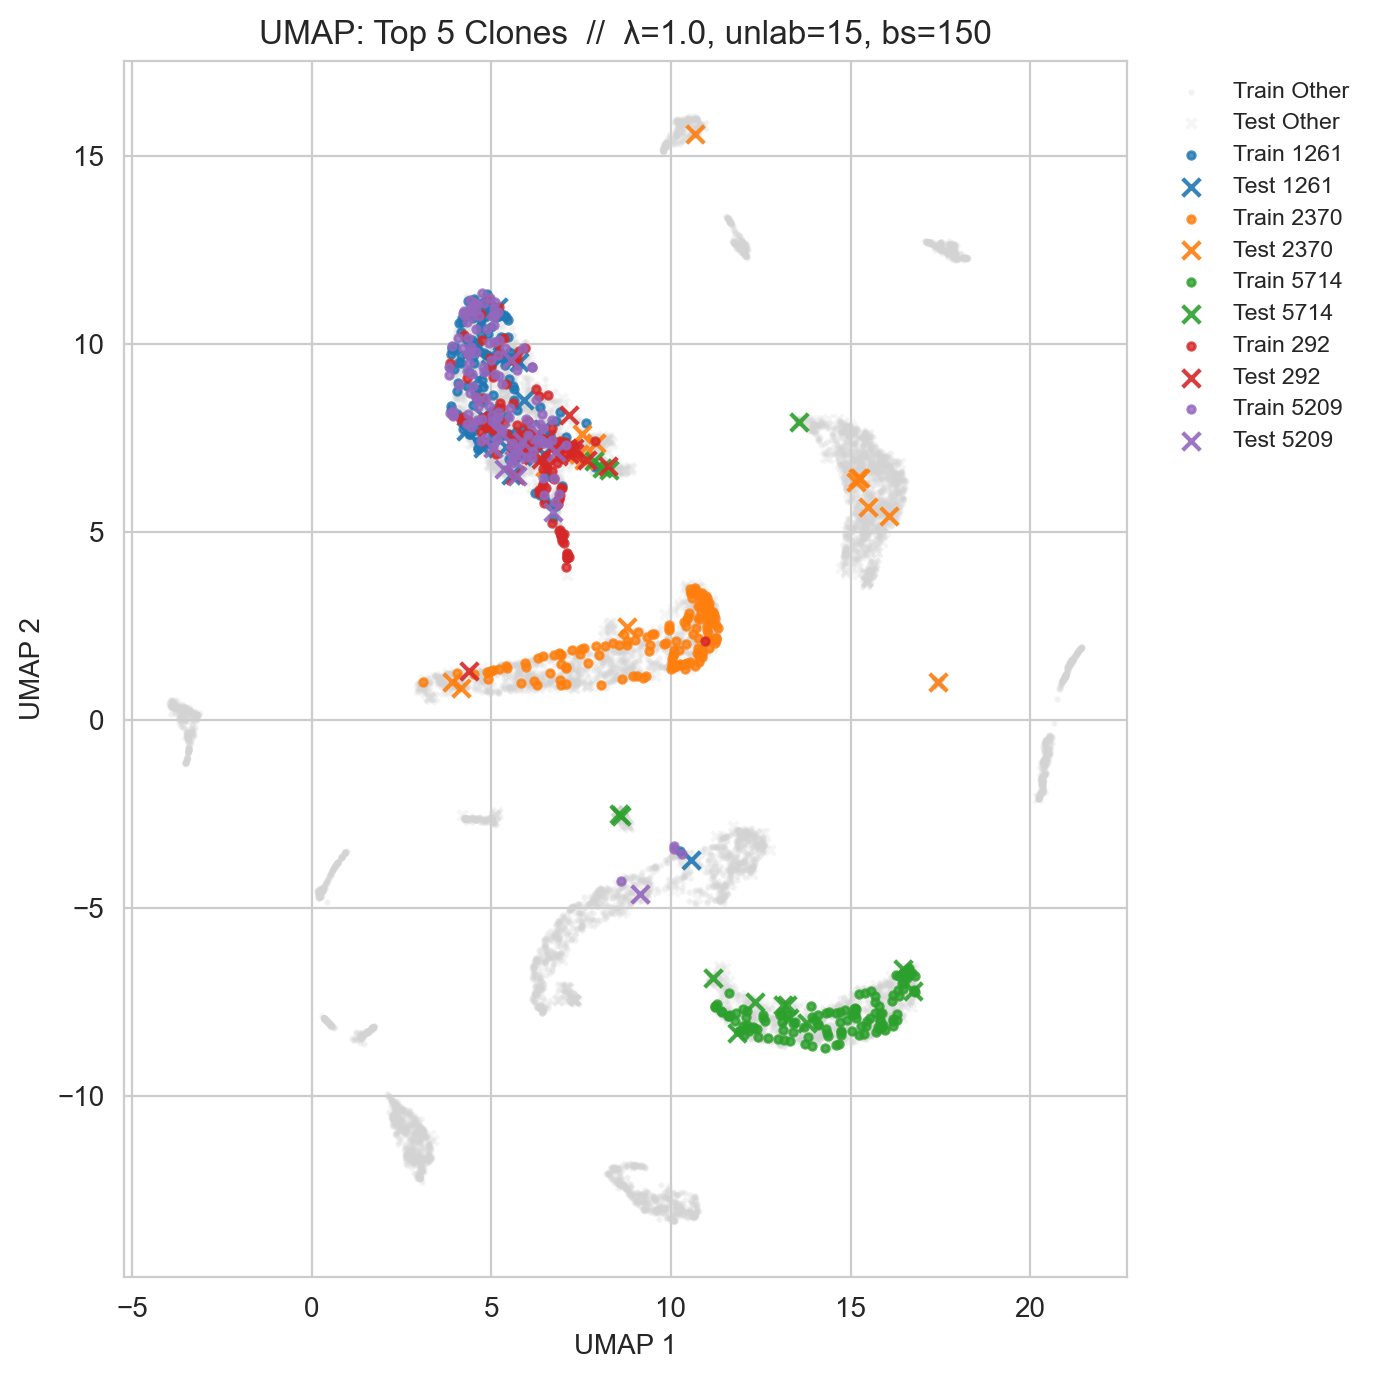

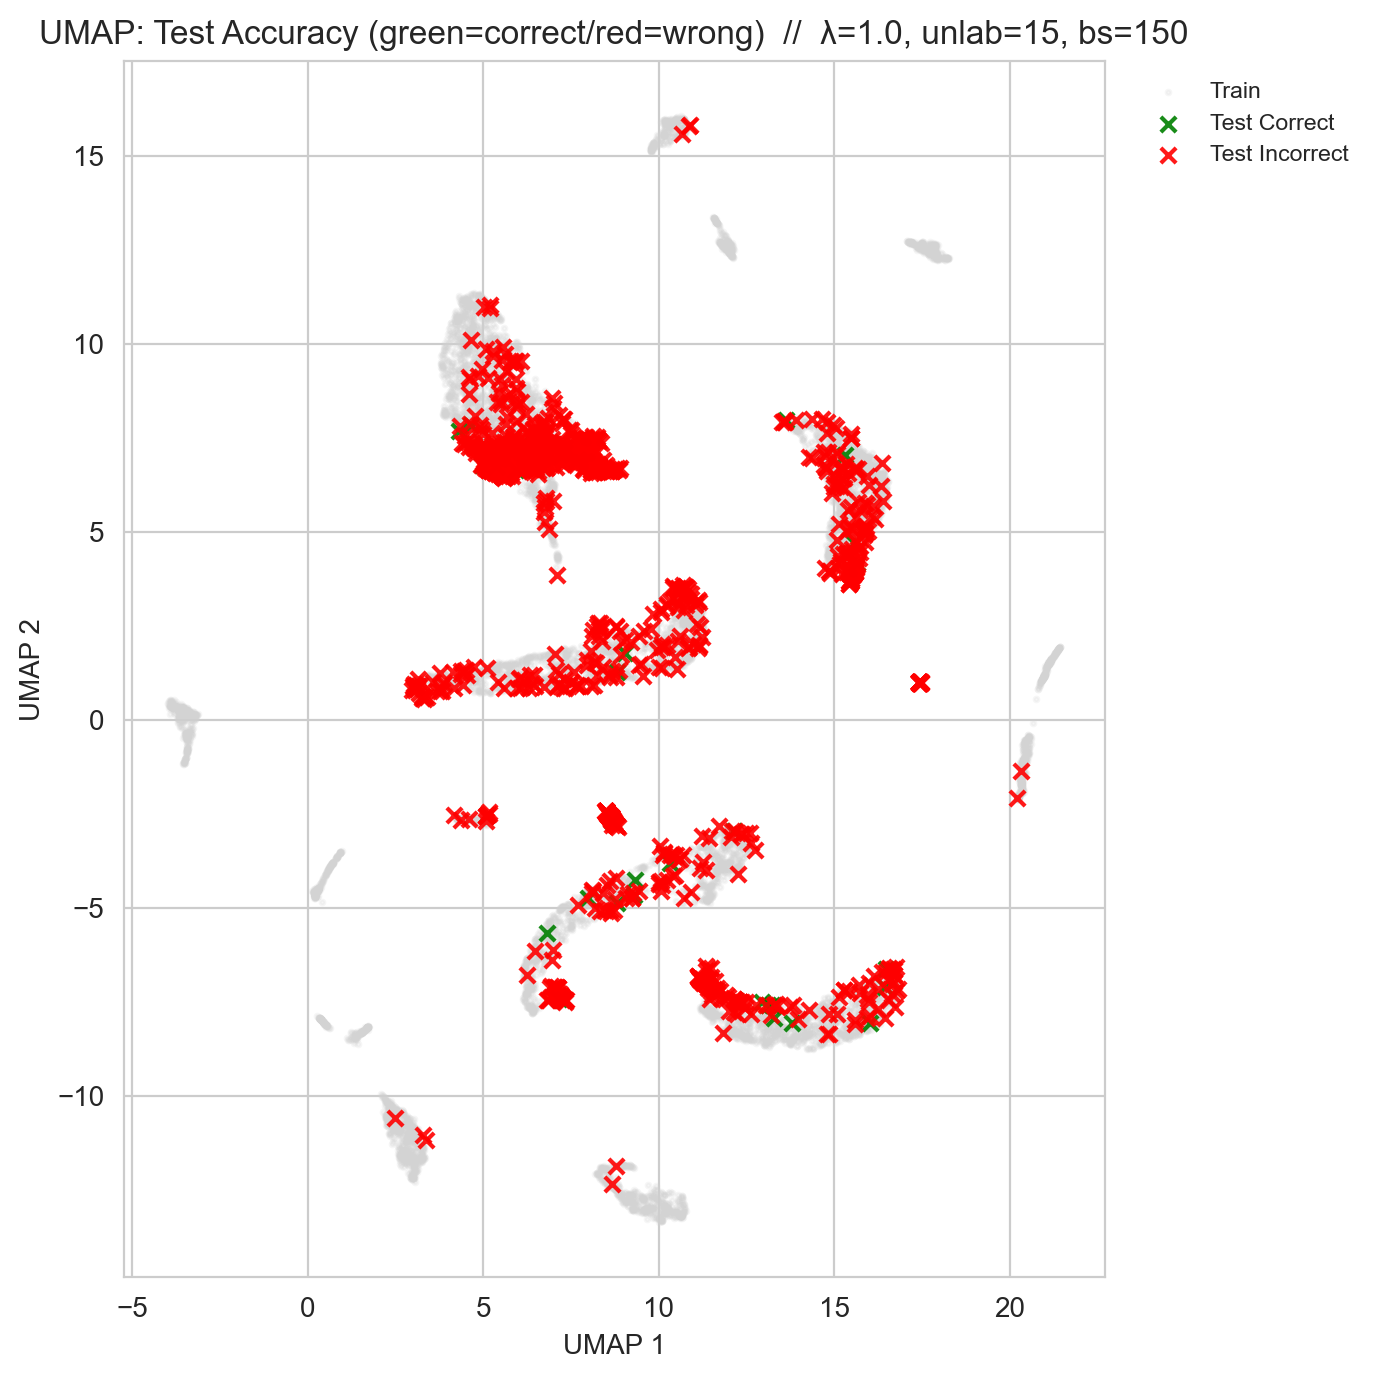

In [3]:
INPUT_DIR  = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200/grid_search_testAsPenalty_1"
TRAIN_ANND = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad"
TEST_ANND  = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad"

adata_train = ad.read_h5ad(TRAIN_ANND)
adata_test  = ad.read_h5ad(TEST_ANND)

# Extract the true label arrays:
train_labels = adata_train.obs["clone_id"].to_numpy()
test_labels  = adata_test.obs["clone_id"].to_numpy()

records = []

# ───────────────────────────────────────────────────────────────────────────────
# Loop over each experiment‐folder (e.g., "lambda0.01_unlab15_bs150", etc.)
# ───────────────────────────────────────────────────────────────────────────────
for exp_name in sorted(os.listdir(INPUT_DIR)):
    exp_path = os.path.join(INPUT_DIR, exp_name)
    if not os.path.isdir(exp_path):
        continue

    # ───────────────────────────────────────────────────────────────────────────
    # Step A: find the two .npy files (train‐embedding & test‐embedding)
    # ───────────────────────────────────────────────────────────────────────────
    all_files = os.listdir(exp_path)
    # 1) training embedding (.npy starting with "scBaseEncoderFeat_Z")
    tr_file = next(
        fn for fn in all_files
        if fn.startswith("scBaseEncoderFeat_Z") and fn.endswith(".npy")
    )
    # 2) testing embedding (either "test_embedding" or startswith "scBaseEncoderFeat_test")
    te_file = next(
        fn for fn in all_files
        if ("test_embedding" in fn) or fn.startswith("scBaseEncoderFeat_test")
    )

    train_emb = np.load(os.path.join(exp_path, tr_file))
    test_emb  = np.load(os.path.join(exp_path, te_file))

    # ───────────────────────────────────────────────────────────────────────────
    # Step B: Build combined AnnData, attach embeddings + "dataset" column
    # ───────────────────────────────────────────────────────────────────────────
    tr_copy = adata_train.copy()
    te_copy = adata_test.copy()

    tr_copy.obsm["LCL_embedding"] = train_emb
    te_copy.obsm["LCL_embedding"] = test_emb
    tr_copy.obs["dataset"]         = "train"
    te_copy.obs["dataset"]         = "test"

    adata_all = ad.concat([tr_copy, te_copy], axis=0, join="outer")

    # ───────────────────────────────────────────────────────────────────────────
    # Step C: Instantiate your LCL_Eval helper
    # ───────────────────────────────────────────────────────────────────────────
    plotter = LCL_Eval(
        adata       = adata_all,
        clone_key   = "clone_id",
        dataset_key = "dataset",
        num_top     = 5,
        palette     = None,               
        umap_kwargs = {"random_state": 42}
    )

    # ───────────────────────────────────────────────────────────────────────────
    # Step D: Run the adjusted‐KNN evaluation on (train_emb, train_labels) & (test_emb, test_labels)
    # ───────────────────────────────────────────────────────────────────────────
    knn_stats = plotter.evaluate_adjusted_knn(
        train_embeddings = train_emb,
        train_labels     = train_labels,
        test_embeddings  = test_emb,
        test_labels      = test_labels,
        k                = 30
    )

    # Parse λ, unlab, bs from the folder‐name:
    lam   = float(exp_name.split("_")[0].replace("lambda", ""))
    unlab = int(exp_name.split("_")[1].replace("unlab", ""))
    bs    = int(exp_name.split("_")[2].replace("bs", ""))

    # Unpack exactly the six values you requested:
    train_overall_acc  = knn_stats["train"]["overall_accuracy"]
    train_overall_rank = knn_stats["train"]["overall_avg_rank"]
    train_qs           = knn_stats["train"]["rank_quantiles"]
    test_overall_acc   = knn_stats["test"]["overall_accuracy"]
    test_overall_rank  = knn_stats["test"]["overall_avg_rank"]
    test_qs            = knn_stats["test"]["rank_quantiles"]

    # ───────────────────────────────────────────────────────────────────────────
    # Step E: Produce UMAP #1 → Top‐5 clones Highlight
    # ───────────────────────────────────────────────────────────────────────────
    fig1, ax1 = plotter.plot_top_clones_umap(
        figsize  = (7, 7),
        title    = f"UMAP: Top 5 Clones  //  λ={lam}, unlab={unlab}, bs={bs}",
        savepath = os.path.join(
            exp_path,
            f"umap_top5clones_lambda{lam}_unlab{unlab}_bs{bs}.pdf"
        )
    )
    # (Figure is saved automatically; we do not call plt.show() here.)

    # ───────────────────────────────────────────────────────────────────────────
    # Step F: Produce UMAP #2 → Test‐cell Accuracy coloring
    # ───────────────────────────────────────────────────────────────────────────
    fig2, ax2 = plotter.plot_test_accuracy_umap(
        train_embeddings   = train_emb,
        train_labels       = train_labels,
        test_embeddings    = test_emb,
        test_labels        = test_labels,
        k                  = 30,
        figsize            = (7, 7),
        title              = f"UMAP: Test Accuracy (green=correct/red=wrong)  //  λ={lam}, unlab={unlab}, bs={bs}",
        savepath           = os.path.join(
            exp_path,
            f"umap_testAccuracy_lambda{lam}_unlab{unlab}_bs{bs}.pdf"
        )
    )
    # (Figure is saved automatically.)

    # ───────────────────────────────────────────────────────────────────────────
    # Step G: Record exactly six stats:
    #   train_overall_acc,  train_overall_rank,  train_q25/50/75,
    #   test_overall_acc,   test_overall_rank,   test_q25/50/75
    # ───────────────────────────────────────────────────────────────────────────
    records.append({
        "lambda":            lam,
        "unlabeled_per_batch": unlab,
        "batch_size":        bs,
        "train_overall_acc": round(train_overall_acc,  4),
        "train_overall_rank":round(train_overall_rank, 4),
        "train_q25":         round(train_qs["q25"],     4),
        "train_q50":         round(train_qs["q50"],     4),
        "train_q75":         round(train_qs["q75"],     4),
        "test_overall_acc":  round(test_overall_acc,  4),
        "test_overall_rank": round(test_overall_rank, 4),
        "test_q25":          round(test_qs["q25"],      4),
        "test_q50":          round(test_qs["q50"],      4),
        "test_q75":          round(test_qs["q75"],      4),
    })

# ───────────────────────────────────────────────────────────────────────────────────────────────────────────
# Step H: Build a single DataFrame and print/save it
# ───────────────────────────────────────────────────────────────────────────────────────────────────────────
df = pd.DataFrame(records)
print(df)

# (Optionally save to CSV in the parent directory)
out_csv = os.path.join(INPUT_DIR, "grid_search_summary.csv")
df.to_csv(out_csv, index=False)
print(f">>> Summary CSV saved to: {out_csv}")

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main_semi_test/LCL_eval_final.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nbr_labels = train_labels[nbrs]
/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSe

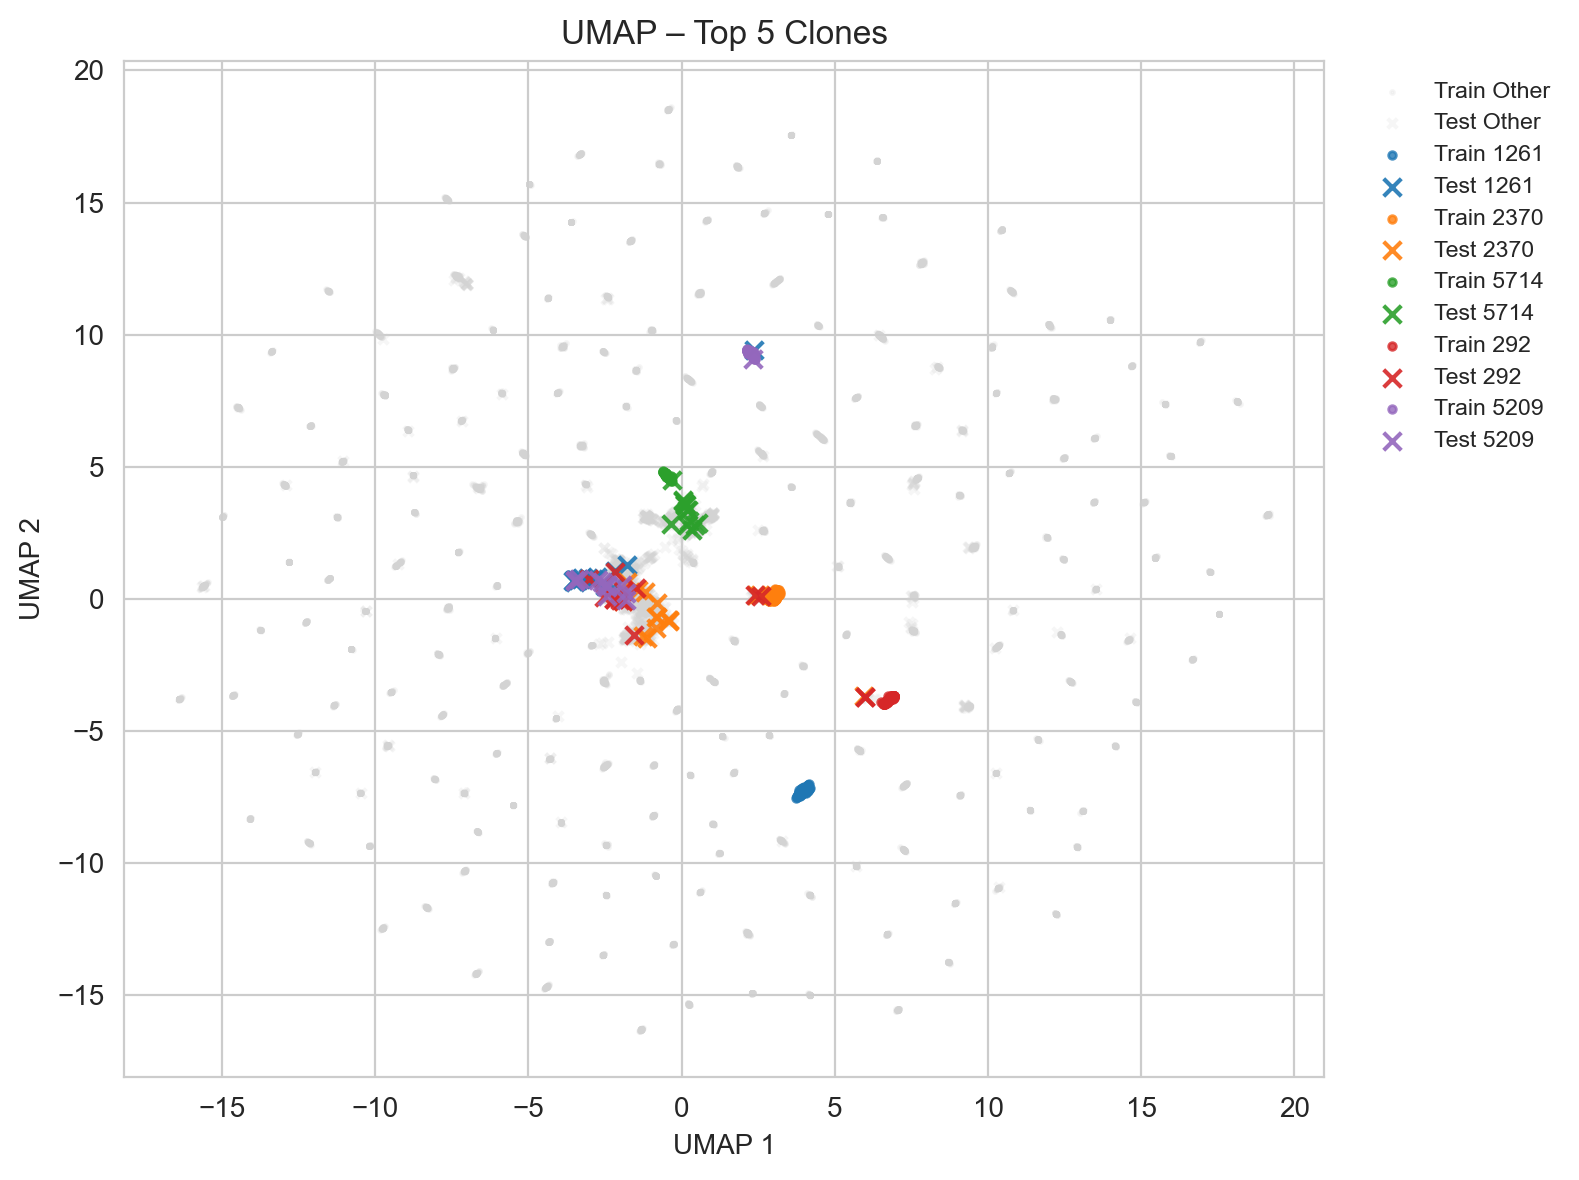

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


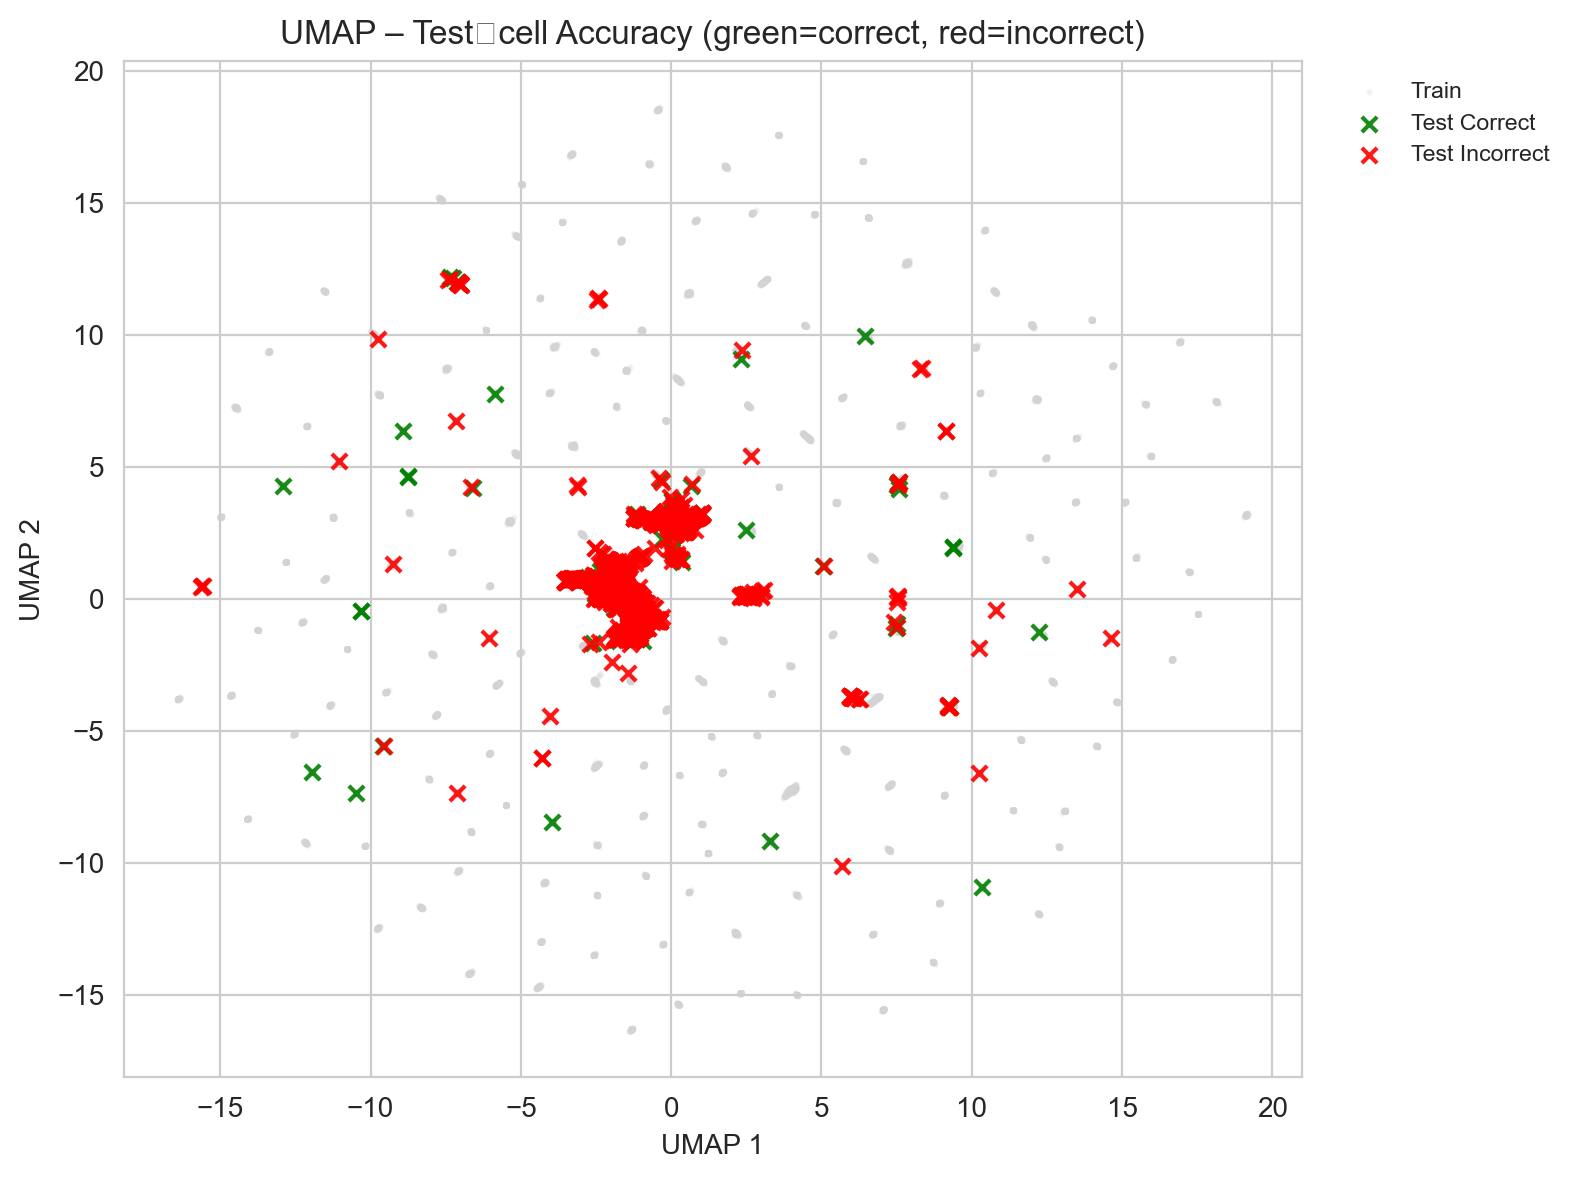

In [ ]:
adata_train = ad.read_h5ad('/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad')
adata_test  = ad.read_h5ad('/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad')

INPUT_DIR = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200"

train_embedding = np.load(INPUT_DIR+'/lambda0.01_unlab15_bs150_testAsPenalty/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_embedding = np.load(INPUT_DIR+'/lambda0.01_unlab15_bs150_testAsPenalty/test_embedding.npy')


adata_train.obsm["LCL_embedding"] = train_embedding
adata_test.obsm["LCL_embedding"]  = test_embedding

# 3) Mark which cells are train vs. test
adata_train.obs["dataset"] = "train"
adata_test.obs["dataset"]  = "test"

# 4) Concatenate them
adata = ad.concat([adata_train, adata_test], axis=0, join="outer")

plotter = LCL_eval_final.LCL_Eval(
    adata=adata,
    clone_key="clone_id",
    dataset_key="dataset",
    num_top=5,             
    palette=None,    
    umap_kwargs={"random_state": 42}
)

knn_stats = plotter.evaluate_adjusted_knn(
    train_embeddings=adata_train.obsm["LCL_embedding"],
    train_labels=adata_train.obs["clone_id"],
    test_embeddings=adata_test.obsm["LCL_embedding"],
    test_labels=adata_test.obs["clone_id"],
    k=30
)

fig1, ax1 = plotter.plot_top_clones_umap(
    train_point_size=25,   # e.g. make train dots a bit smaller
    test_point_size=50,    # e.g. make test crosses a bit larger
    title="UMAP: Top 5 Clones (Train vs Test)",
    savepath="umap_top_clones.pdf",
    figsize=(7,7)
)
fig2, ax2 = plotter.plot_test_accuracy_umap(
    train_point_size=6,        # size for all train cells (gray dots)
    test_correct_size=35,      # size for test‐correct (green crosses)
    test_incorrect_size=35,    # size for test‐incorrect (red crosses)
    title="UMAP: Test‐cell Accuracy (green=correct, red=incorrect)",
    savepath="umap_test_accuracy.pdf",
    figsize=(7,7)
)


In [6]:
knn_stats

{'train': {'overall_accuracy': 1.0,
  'overall_avg_rank': 1.0,
  'overall_avg_unique': 1.0,
  'rank_quantiles': {'q25': 1.0, 'q50': 1.0, 'q75': 1.0}},
 'test': {'overall_accuracy': 0.11879358060240414,
  'overall_avg_rank': 2.1114277258689023,
  'overall_avg_unique': 1.2514285714285713,
  'rank_quantiles': {'q25': 1.897, 'q50': 2.0, 'q75': 2.333}}}

In [8]:
results = evaluate_adjusted_knn(
    train_embeddings = adata_train.obsm["LCL_embedding"],
    train_labels     = adata_train.obs["clone_id"],
    test_embeddings  = adata_test.obsm["LCL_embedding"],
    test_labels      = adata_test.obs["clone_id"],
    k                = 30
)

# `results` is now a dictionary with the structure described above. For example:
print("Train overall accuracy:", results["train"]["overall_accuracy"])
print("Train rank‐quantiles:",   results["train"]["rank_quantiles"])
print("Test  overall accuracy:", results["test"]["overall_accuracy"])
print("Test  rank‐quantiles:",   results["test"]["rank_quantiles"])

/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main_semi_test/LCL_eval_modifiedKNN_copy.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nbr_labels = train_labels[nbrs]
/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main_semi_test/LCL_eval_modifiedKNN_copy.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_lab = labels_true[i]


Train overall accuracy: 1.0
Train rank‐quantiles: {'q25': 1.0, 'q50': 1.0, 'q75': 1.0}
Test  overall accuracy: 0.11879358060240414
Test  rank‐quantiles: {'q25': 1.8972222222222221, 'q50': 2.0, 'q75': 2.3333333333333335}


/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main_semi_test/LCL_eval_modifiedKNN_copy.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nbr_labels = train_labels[nbrs]
/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main_semi_test/LCL_eval_modifiedKNN_copy.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_lab = labels_true[i]


In [4]:
plotter = LCL_eval_new.LCL_Eval(
    adata=adata,
    clone_key="clone_id",
    dataset_key="dataset",
    num_top=5,            # highlight top 5 clones
    palette=None,         # default seaborn “tab10” for those top‐5
    umap_kwargs={"random_state":42}
)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


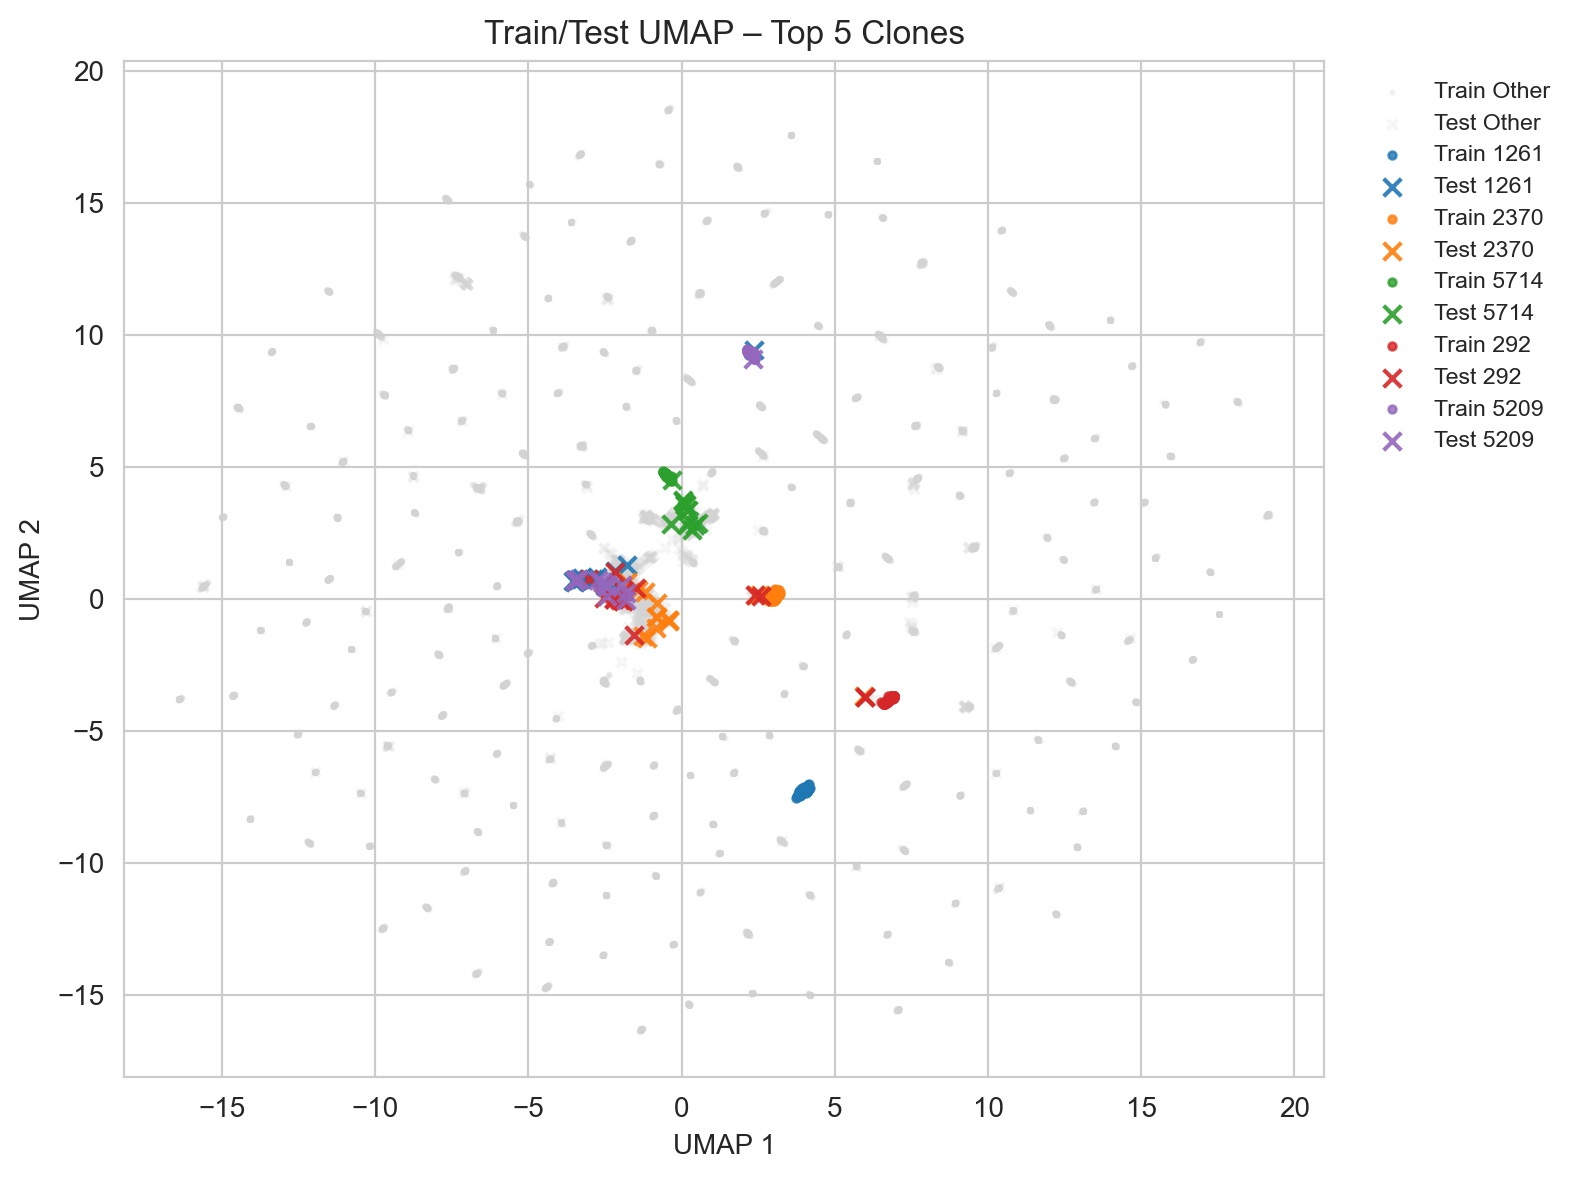

In [5]:

# 6) Draw & optionally save to PDF
fig, ax = plotter.plot_umap(
    figsize=(8,6), 
    title="Train/Test UMAP – Top 5 Clones", 
    savepath="umap_top5.pdf"
)

In [ ]:
records = []

for grid_name in sorted(os.listdir(INPUT_DIR)):
    grid_path = os.path.join(INPUT_DIR, grid_name)
    if not os.path.isdir(grid_path): continue

    for exp_name in sorted(os.listdir(grid_path)):
        exp_path = os.path.join(grid_path, exp_name)
        if not os.path.isdir(exp_path): continue

        # find your two .npy files
        files = os.listdir(exp_path)
        tr_file = next(f for f in files if f.startswith("scBaseEncoderFeat_Z") and f.endswith(".npy"))
        te_file = next(f for f in files if "test_embedding" in f or f.startswith("scBaseEncoderFeat_test"))

        train_emb = np.load(os.path.join(exp_path, tr_file))
        test_emb = np.load(os.path.join(exp_path, te_file))

        # Original KNN evaluation
        ev = LCL_eval.Eval(train_emb, TRAIN_ADATA)
        orig_tr_acc = ev.KNN_train(n_neighbors=5)
        orig_te_acc = ev.KNN_test(test_emb, TEST_ADATA, n_neighbors=5)

        # Modified KNN classifier (sklearn-based)
        knn_model = KNeighborsClassifier(n_neighbors=30)
        knn_model.fit(train_emb, train_labels)

        preds_mod1_train, _, avg_rank_mod1_train, _ = adjusted_knn_predict_with_rank(
            knn_model, train_labels, train_emb, train_labels, global_freq, k=30)
        preds_mod1_test, _, avg_rank_mod1_test, _ = adjusted_knn_predict_with_rank(
            knn_model, train_labels, test_emb, test_labels, global_freq, k=30)

        mod1_tr_acc = (preds_mod1_train == train_labels).mean()
        mod1_te_acc = (preds_mod1_test == test_labels).mean()

        # Modified KNN classifier v2 (distance-based)
        preds_mod2_train, _, avg_rank_mod2_train, _ = adjusted_knn_predict_with_rank_v2(
            train_emb, train_labels, train_emb, train_labels, global_freq, k=30)
        preds_mod2_test, _, avg_rank_mod2_test, _ = adjusted_knn_predict_with_rank_v2(
            train_emb, train_labels, test_emb, test_labels, global_freq, k=30)

        mod2_tr_acc = (preds_mod2_train == train_labels).mean()
        mod2_te_acc = (preds_mod2_test == test_labels).mean()

        # parse hyperparams out of exp_name
        lam, unlab, bs = exp_name.split("_")
        lam = float(lam.replace("lambda", ""))
        unlab = int(unlab.replace("unlab", ""))
        bs = int(bs.replace("bs", ""))

        # Record results
        records.append({
            "grid": grid_name,
            "lambda": lam,
            "unlabeled": unlab,
            "batch_size": bs,

            # Original KNN accuracy
            "orig_train_acc": orig_tr_acc,
            "orig_test_acc": orig_te_acc,

            # Modified KNN v1 accuracy
            "mod1_train_acc": mod1_tr_acc,
            "mod1_test_acc": mod1_te_acc,
            "mod1_avg_rank_train": avg_rank_mod1_train,
            "mod1_avg_rank_test": avg_rank_mod1_test,

            # Modified KNN v2 accuracy
            "mod2_train_acc": mod2_tr_acc,
            "mod2_test_acc": mod2_te_acc,
            "mod2_avg_rank_train": avg_rank_mod2_train,
            "mod2_avg_rank_test": avg_rank_mod2_test
        })

# Create summary DataFrame
df = pd.DataFrame(records)
print(df)



In [ ]:
df

### anndata loading

In [ ]:
records = []

for grid_name in sorted(os.listdir(INPUT_DIR)):
    grid_path = os.path.join(INPUT_DIR, grid_name)
    if not os.path.isdir(grid_path): continue

    for exp_name in sorted(os.listdir(grid_path)):
        exp_path = os.path.join(grid_path, exp_name)
        if not os.path.isdir(exp_path): continue

        # find your two .npy files
        files = os.listdir(exp_path)
        tr_file = next(f for f in files if f.startswith("scBaseEncoderFeat_Z") and f.endswith(".npy"))
        te_file = next(f for f in files if "test_embedding" in f or f.startswith("scBaseEncoderFeat_test"))

        train_emb = np.load(os.path.join(exp_path, tr_file))
        test_emb = np.load(os.path.join(exp_path, te_file))

        # Original KNN evaluation
        ev = LCL_eval.Eval(train_emb, TRAIN_ADATA)
        orig_tr_acc = ev.KNN_train(n_neighbors=5)
        orig_te_acc = ev.KNN_test(test_emb, TEST_ADATA, n_neighbors=30)

        # Modified KNN classifier (sklearn-based)
        knn_model = KNeighborsClassifier(n_neighbors=30)
        knn_model.fit(train_emb, train_labels)

        preds_mod1_train, _, avg_rank_mod1_train, _ = adjusted_knn_predict_with_rank(
            knn_model, train_labels, train_emb, train_labels, global_freq, k=30)
        preds_mod1_test, _, avg_rank_mod1_test, _ = adjusted_knn_predict_with_rank(
            knn_model, train_labels, test_emb, test_labels, global_freq, k=30)

        mod1_tr_acc = (preds_mod1_train == train_labels).mean()
        mod1_te_acc = (preds_mod1_test == test_labels).mean()

        # Modified KNN classifier v2 (distance-based)
        preds_mod2_train, _, avg_rank_mod2_train, _ = adjusted_knn_predict_with_rank_v2(
            train_emb, train_labels, train_emb, train_labels, global_freq, k=30)
        preds_mod2_test, _, avg_rank_mod2_test, _ = adjusted_knn_predict_with_rank_v2(
            train_emb, train_labels, test_emb, test_labels, global_freq, k=30)

        mod2_tr_acc = (preds_mod2_train == train_labels).mean()
        mod2_te_acc = (preds_mod2_test == test_labels).mean()

        # parse hyperparams out of exp_name
        lam, unlab, bs = exp_name.split("_")
        lam = float(lam.replace("lambda", ""))
        unlab = int(unlab.replace("unlab", ""))
        bs = int(bs.replace("bs", ""))

        # Record results
        records.append({
            "grid": grid_name,
            "lambda": lam,
            "unlabeled": unlab,
            "batch_size": bs,

            # Original KNN accuracy
            "orig_train_acc": orig_tr_acc,
            "orig_test_acc": orig_te_acc,

            # Modified KNN v1 accuracy
            "mod1_train_acc": mod1_tr_acc,
            "mod1_test_acc": mod1_te_acc,
            "mod1_avg_rank_train": avg_rank_mod1_train,
            "mod1_avg_rank_test": avg_rank_mod1_test,

            # Modified KNN v2 accuracy
            "mod2_train_acc": mod2_tr_acc,
            "mod2_test_acc": mod2_te_acc,
            "mod2_avg_rank_train": avg_rank_mod2_train,
            "mod2_avg_rank_test": avg_rank_mod2_test
        })

# Create summary DataFrame
df = pd.DataFrame(records)
print(df)



In [ ]:
df

In [ ]:
df.to_csv("knn_evaluation_summary.csv", index=False)

In [ ]:
adata_train = ad.read_h5ad('/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad')
adata_test  = ad.read_h5ad('/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad')

INPUT_DIR = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200/feat_semi_sup_grid_search"

train_semi_10 = np.load(INPUT_DIR+'/grid_search_3/lambda0.3_unlab15_bs150/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_semi_10 = np.load(INPUT_DIR+'/grid_search_3/lambda0.3_unlab15_bs150/test_embedding.npy')


In [ ]:
adata_train = ad.read_h5ad('/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad')
adata_test  = ad.read_h5ad('/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad')

INPUT_DIR = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200"

train_semi_10 = np.load(INPUT_DIR+'/lambda0.01_unlab15_bs150_testAsPenalty/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_semi_10 = np.load(INPUT_DIR+'/lambda0.01_unlab15_bs150_testAsPenalty/test_embedding.npy')


In [ ]:
adata_train.obsm["LCL_embedding_semi_10"] = train_semi_10
adata_test.obsm["LCL_embedding_semi_10"] = test_semi_10

adata_train.obs["dataset"] = "train"
adata_test.obs["dataset"] = "test"

adata = ad.concat([adata_train, adata_test], axis=0, join='outer')

In [ ]:
import umap

reducer = umap.UMAP()

embedding_umap = reducer.fit_transform(adata.obsm["LCL_embedding_semi_10"])

adata.obsm["X_umap"] = embedding_umap

In [ ]:
import pandas as pd

# Count number of cells per lineage
clone_counts = adata.obs["clone_id"].value_counts()

# Get the top 5 largest lineages
top_5_clones = clone_counts.index[:5]

# Assign 'Other' to all lineages except the top 5
adata.obs["clone_group"] = adata.obs["clone_id"].apply(lambda x: x if x in top_5_clones else "Other")

# Convert to categorical
adata.obs["clone_group"] = adata.obs["clone_group"].astype("category")

# Print for verification
print(adata.obs["clone_group"].value_counts())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_umap(adata, colormap="tab10"):
    """
    Plots UMAP with:
    - Top 5 clones in distinct colors (plotted on top)
    - Other clones in gray with lower opacity
    - Train cells as dots, Test cells as crosses
    - Larger marker size for top 5 clones
    """
    umap_coords = adata.obsm["X_umap"]

    # Extract train and test indices
    train_idx = adata.obs["dataset"] == "train"
    test_idx = adata.obs["dataset"] == "test"

    # Get unique clone groups
    unique_clones = adata.obs["clone_group"].cat.categories

    # Define a colormap for the top 5 clones, others in gray
    colors = plt.get_cmap(colormap)(range(len(unique_clones) - 1))  # Leave space for gray
    color_map = dict(zip(unique_clones[:-1], colors))  # Map top 5 clones
    color_map["Other"] = "gray"  # Set 'Other' to gray

    plt.figure(figsize=(8, 6))

    # **Step 1**: Plot "Other" cells first (background with low opacity)
    idx_train_other = (adata.obs["clone_group"] == "Other") & train_idx
    idx_test_other = (adata.obs["clone_group"] == "Other") & test_idx

    plt.scatter(umap_coords[idx_train_other, 0], umap_coords[idx_train_other, 1], 
                color=color_map["Other"], s=8, marker=".", alpha=0.2, label="Train Other")  # Lower opacity

    plt.scatter(umap_coords[idx_test_other, 0], umap_coords[idx_test_other, 1], 
                color=color_map["Other"], s=12, marker="x", alpha=0.2, label="Test Other")  # Lower opacity

    # **Step 2**: Plot top 5 clones on top (larger size)
    for clone in unique_clones[:-1]:  # Skip "Other"
        idx_train = (adata.obs["clone_group"] == clone) & train_idx
        idx_test = (adata.obs["clone_group"] == clone) & test_idx

        # Train: Dots
        plt.scatter(umap_coords[idx_train, 0], umap_coords[idx_train, 1], 
                    color=color_map[clone], s=30, marker=".", alpha=0.8, label=f"Train {clone}")  # Bigger size

        # Test: Crosses
        plt.scatter(umap_coords[idx_test, 0], umap_coords[idx_test, 1], 
                    color=color_map[clone], s=40, marker="x", alpha=0.9, label=f"Test {clone}")  # Bigger size

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title("UMAP Projection - Top 5 Clones Highlighted")
    plt.legend()
    plt.show()

# Run the function to plot
plot_umap(adata)

### Train 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_umap_with_lineages(adata, n_top_lineages=5, colormap="tab10"):
    """
    Plots UMAP from `adata.obsm["X_umap"]` with:
    - Top N clones in distinct colors (plotted on top)
    - Other clones in gray with lower opacity
    - Train cells as dots, Test cells as crosses
    
    Parameters:
    - adata (AnnData): AnnData object with precomputed UMAP in `.obsm["X_umap"]`
    - n_top_lineages (int): Number of largest lineages to highlight in the plot
    - colormap (str): Matplotlib colormap for the distinct top N lineages
    
    Output:
    - A UMAP scatter plot (does NOT modify `adata`)
    """

    ### **1️⃣ Check If Required Fields Exist**
    if "X_umap" not in adata.obsm:
        raise ValueError("UMAP coordinates missing! Ensure `adata.obsm['X_umap']` is computed.")
    
    if "LCL_embedding_semi_10" not in adata.obsm:
        raise ValueError("Contrastive learning embeddings missing! Ensure `adata.obsm['LCL_embedding_dim10']` exists.")
    
    if "clone_id" not in adata.obs:
        raise ValueError("Clone ID column missing! Ensure `adata.obs['clone_id']` exists.")
    
    if "dataset" not in adata.obs:
        raise ValueError("Dataset column missing! Ensure `adata.obs['dataset']` exists with 'train' and 'test' values.")

    ### **2️⃣ Identify the Top N Largest Lineages**
    print(f"Identifying the top {n_top_lineages} largest lineages...")
    clone_counts = adata.obs["clone_id"].value_counts()
    top_n_clones = clone_counts.index[:n_top_lineages]

    # Assign "Other" to all but the top N lineages
    adata.obs["clone_group"] = adata.obs["clone_id"].apply(lambda x: x if x in top_n_clones else "Other")
    
    # Convert to categorical for easy plotting
    adata.obs["clone_group"] = adata.obs["clone_group"].astype("category")

    ### **3️⃣ Plot UMAP with Custom Formatting**
    print("Plotting UMAP with lineage-specific colors and train/test markers...")

    umap_coords = adata.obsm["X_umap"]
    train_idx = adata.obs["dataset"] == "train"
    test_idx = adata.obs["dataset"] == "test"
    
    unique_clones = adata.obs["clone_group"].cat.categories

    # Define a colormap for the top N clones, others in gray
    colors = plt.get_cmap(colormap)(range(len(unique_clones) - 1))  # Leave space for gray
    color_map = dict(zip(unique_clones[:-1], colors))  # Map top N clones
    color_map["Other"] = "gray"  # Set 'Other' to gray

    plt.figure(figsize=(8, 6))

    # **Step 1**: Plot "Other" cells first (background with low opacity)
    idx_train_other = (adata.obs["clone_group"] == "Other") & train_idx
    idx_test_other = (adata.obs["clone_group"] == "Other") & test_idx

    plt.scatter(umap_coords[idx_train_other, 0], umap_coords[idx_train_other, 1], 
                color=color_map["Other"], s=8, marker=".", alpha=0.2, label="Train Other")

    plt.scatter(umap_coords[idx_test_other, 0], umap_coords[idx_test_other, 1], 
                color=color_map["Other"], s=8, marker="x", alpha=0.2, label="Test Other")

    # **Step 2**: Plot top N clones on top (larger size)
    for clone in unique_clones[:-1]:  # Skip "Other"
        idx_train = (adata.obs["clone_group"] == clone) & train_idx
        idx_test = (adata.obs["clone_group"] == clone) & test_idx

        # Train: Dots
        plt.scatter(umap_coords[idx_train, 0], umap_coords[idx_train, 1], 
                    color=color_map[clone], s=40, marker=".", alpha=0.8, label=f"Train {clone}")

        # Test: Crosses
        plt.scatter(umap_coords[idx_test, 0], umap_coords[idx_test, 1], 
                    color=color_map[clone], s=40, marker="x", alpha=1, label=f"Test {clone}")

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"UMAP Projection - Top {n_top_lineages} Clones Highlighted")
    plt.legend()
    plt.show()

In [ ]:
plot_umap_with_lineages(adata, n_top_lineages=1)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(embedding_umap[:,0],embedding_umap[:,1])

In [ ]:
plt.scatter(embedding_umap[:10147,0],embedding_umap[:10147,1])

In [ ]:
plt.scatter(embedding_umap[10148:,0],embedding_umap[10148:,1])

In [ ]:
eval_semi_10_train = LCL_eval.Eval(train_semi_10, adata_train)
eval_semi_10_train.plot_umap_top_lin("semi-supervised learning with 5 unlabeled data")
eval_semi_10_train.KNN_train()
score_10_train = eval_semi_10_train.calculate_calinski_harabasz_score()

In [ ]:
eval_semi_10_test = LCL_eval.Eval(test_semi_10, adata_test)
eval_semi_10_test.plot_umap_top_lin("semi-supervised learning with 5 unlabeled data")
score_semi_10_test = eval_semi_10_test.calculate_calinski_harabasz_score()
eval_semi_10_train.KNN_test(test_semi_10, adata_test)

In [ ]:
adata_train = ad.read_h5ad('/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad')
adata_test  = ad.read_h5ad('/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad')

INPUT_DIR = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200"

train_semi_001 = np.load(INPUT_DIR+'/lambda0.01_unlab15_bs150_testAsPenalty/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_semi_001 = np.load(INPUT_DIR+'/lambda0.01_unlab15_bs150_testAsPenalty/test_embedding.npy')


In [ ]:
ev = LCL_eval.Eval(train_semi_001, adata_train)
tr_acc = ev.KNN_train(n_neighbors=5)
te_acc = ev.KNN_test(test_semi_001, adata_test, n_neighbors=5)